# Applause analysis for Music Science paper
Extending and adapting the analysis of audience clapping captured during the MusicLab Copenhagen concert experiment for a presentation at CIM 2022.

## Figures and numerical results
- Clap extraction
- Stats on applause rounds
- Stats on Applauders
- Dynamics of synchronous applause (ICI convergence)
- Textures of partial synchrony applause
- Applause as stage responsive collective action (cues for start and stop....)


In [29]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt,find_peaks
from scipy.interpolate import interp1d
import imageio

pd.options.mode.chained_assignment = None

In [20]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%reload_ext autoreload

## definitions 

In [28]:
# functions

def rms_signal(data, window_size, shift):
  # data is pandas Series of signal
  # function to calculate root mean square using a scrolling window.
  i = int(window_size/2)
  l = data.shape[0]
  rms_y = [np.nan]*l
  while True:
    if i >= l:
      break
    if (i >= window_size/2) and (l-i >= window_size/2):
      in_window  = int(i-window_size/2)
      out_window = int(i+window_size/2)
      data_rms = data.iloc[in_window:out_window]
      if data_rms.isna().sum() < (len(data_rms)):
        data_rms = data_rms.dropna()
      rms_value = math.sqrt(sum([i*i for i in data_rms])/len(data_rms)) if data_rms.isna().sum() == 0 else -1
    else:
      rms_value = np.nan
    rms_y[i] = rms_value
    i = i + shift
  df = pd.DataFrame(index = data.index, columns = ['rms'], data={'rms': rms_y})
  return df

def butter_lowpass_filter(data, cutoff, fs, order):
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = filtfilt(b, a, data)
  return y


# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

### file access

In [21]:
# Now to map those values to locations, need to import some details.
# these are old ID codes, need to replace. 
general_loc = '/Users/finn/Desktop/Current_Projects/Copen/'

internal_Part = general_loc + 'Participants_internal/'


public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [33]:
partDets = pd.read_csv(internal_Part + 'Audience_Mapping_Internal.csv')#,index_col = 0,header_col = 0)
# need only in person participants so cut to those in attendence with seats assinged
# partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'] == 'A',:] # in person hall participant
partDets = partDets.loc[~partDets['X'].isna(),:]
MovingParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
Part_Codes = list(MovingParts.Participant_Code.values)
# alignedParts = MovingParts
# aligned_Part_Codes = list(alignedParts.Participant_Code.values)

In [27]:
Near_Rels = pd.read_csv(public_Part + 'Near_Participants_Hall.csv')
# reduce to list of relationships included in the dataset available here
Sub_Rels = Near_Rels.loc[Near_Rels['Participant_Code_1'].isin(Part_Codes),:]
Sub_Rels = Sub_Rels.loc[Sub_Rels['Participant_Code_2'].isin(Part_Codes),:].reset_index(drop = True)
#Sub_Rels

In [410]:
#claps_folder = './Data/new_indexp/clapping_peaks/'
#claps_folder = '/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/copenhagen-musiclab-clapping/out_claps/clapping_peaks/'
claps_folder = '/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/copenhagen-musiclab-clapping/out_claps/'
os.listdir(claps_folder+'clapping_peaks/')

['Applause_3_speech_2_peaks.csv',
 'Applause_1_entre_1_peaks.csv',
 'Applause_15_finale_peaks.csv',
 'Applause_2_speech_1_peaks.csv',
 'Applause_8_bach_peaks.csv',
 'Applause_10_folk_2_peaks.csv',
 'Applause_11_folk_3_peaks.csv',
 'Applause_9_folk_1_peaks.csv',
 'Applause_4_beethoven_peaks.csv',
 'Applause_6_schnittke_peaks.csv',
 'Applause_12_folk_4_peaks.csv',
 'Applause_13_folk_5_peaks.csv',
 'Applause_5_entre_2_peaks.csv',
 'Applause_7_entre_3_peaks.csv',
 'Applause_14_speech_3_peaks.csv']

# examples claps caught in one round of applause 
We have an issue with what is 0 time in the applause rounds. 
Need to straighten out the time onset time of clapping? 

In [538]:
app_int = 11
partID = 'AEQ087'
applause_rnd = 'Applause_11_folk_3'
print(applause_rnd)
df_motion = pd.read_csv(claps_folder + applause_rnd + '_motion.csv',index_col=0)
df_motion.index = df_motion.index/1000
peaks = pd.read_csv(claps_folder +'clapping_peaks/'+ applause_rnd + '_peaks.csv',index_col=0)

#df_motion[partID]

Applause_11_folk_3


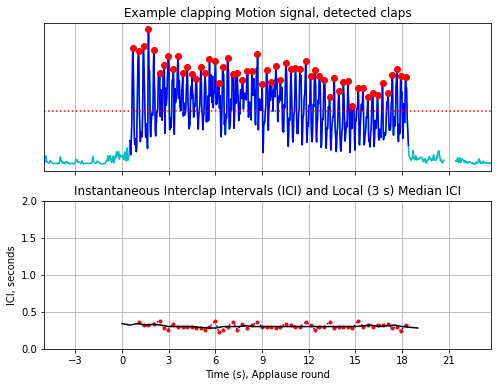

In [539]:
fs = 50
sig = df_motion[partID].copy()
extend_seg = 5 # five seconds was the extension given to the segments being evaluated
extend_ind = 5*fs # segmentation extension, in number of samples
extend = 10 * 0.02 # extending the evaluation windows for peak picking by 0.2 s in samples

seg_len=len(df_motion)

thr=0.01
std_thr = 0.08

rms = rms_signal(sig, fs, 4).dropna().replace(-1,np.nan)
# establish a threshold value for signal rms values where peaks will be counted.
std = np.std(sig)
thr = rms.mean()[0] + std*0.35

# in out pins
# Extends the window for evaluting the peaks by 10 timestamps at both ends (0.2 s)
in_  = max(sig[sig>thr].index.values[0],0) - extend
out_ = min(sig[sig>thr].index.values[-1],sig.index[-1]-extend_seg) + extend
sig.loc[:in_] = np.nan
sig.loc[out_:] = np.nan

# use signal library's find_peaks to pull out peaks in jerk corresponding to clap impacts
peak_index_list = find_peaks(sig.values,distance=10)[0]
#trim peaks based on their height too.
s_plot = sig.iloc[peak_index_list] # get signal values at peaks
s_plot = s_plot[s_plot>thr]

# define region of applause based on acceptable peaks found in motion signal (with 0.2 s extension)
in_peak = s_plot.dropna().iloc[:1].index.values[0] - extend
out_peak = s_plot.dropna().iloc[-1:].index.values[0] + extend
sig.loc[:in_peak] = np.nan
sig.loc[out_peak:] = np.nan

# write to df
sig_peaks = sig.copy()
sig_peaks.loc[:] = np.nan
sig_peaks.loc[s_plot.index] = s_plot.values

# now get ICI
t_interval = 1.5
df_claps = peaks.fillna(0)
df_OnlyClaps = df_claps.astype(bool).astype(int)
total_claps = df_OnlyClaps.sum()
# first and last claps as detected
a = df_OnlyClaps.ne(0).idxmax()
first_claps = a-a.median()
a = df_OnlyClaps.iloc[::-1].ne(0).idxmax()
last_claps = a-a.median()

sampletimes = np.arange(0,df_OnlyClaps.index[-1],0.5)
Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)
for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
#         clap_stats = []
    cols = sub_claps.columns
    these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0,:] = these_claps

ici = pd.Series(index = s_plot.index, data = s_plot.index,dtype='float64').diff()

# plot
f, a = plt.subplots(2,1,figsize=(8,6),sharex = True) 
ax = a[0]
ax.plot(df_motion[partID],'c',sig, 'b-', sig_peaks, 'ro')
ax.plot([sig.index[0],sig.index[-1]],[thr, thr],'r:')
ax.set_yticks([])

ax.set_title('Example clapping Motion signal, detected claps' )
ax.grid()

ax = a[1]
ax.plot(ici,'b:',ici,'r.',Clap_Feats.loc[:,partID],'k-')
ax.set_title('Instantaneous Interclap Intervals (ICI) and Local (3 s) Median ICI' )
ax.set_xlabel('Time (s), Applause round')
ax.set_xticks(range(-3,round(sig.index.max()),3))
ax.set_xlim([sig.index.min(),sig.index.max()])
ax.set_ylim([0,2])
ax.set_ylabel('ICI, seconds')
ax.grid()

plt.savefig('./plots/'+partID+'_clapping_demo.png',bbox_inches = 'tight',dpi = 300)
plt.show()

Applause_6_schnittke_peaks.csv


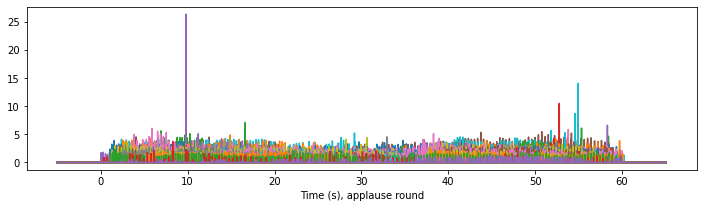

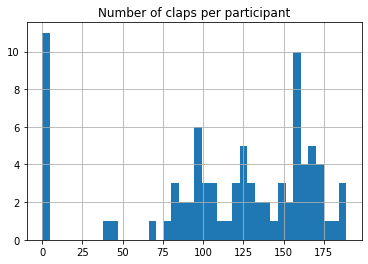

In [540]:
# Example of steps
app_int = 5
print(Applause_ints.loc[app_int,'files'])
peaks = pd.read_csv(claps_folder +'clapping_peaks/'+ Applause_ints.loc[app_int,'files'],index_col=0)
df_claps = peaks.fillna(0)
df_claps.plot(figsize = [12,3],legend = False)
plt.xlabel('Time (s), applause round')
plt.show()

# drop the clap amplitude for simpler analysis and count claps per participant
df_OnlyClaps = df_claps.astype(bool).astype(int)
df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant')
plt.show()

## Clap interval characteristics

In [543]:
#df_motion.index=(pd.to_datetime(df_motion.index))
applause_times = pd.read_csv('data/Applause_Moments.csv',sep=",") #SV alignment for beeps
applause_times = pd.read_csv('data/Applause_stage_events_T2.csv',sep=",") #SV alignment for beeps

# need to add datetime
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

applause_times['datetime'] = Synch_time + pd.to_timedelta(applause_times['concert_time'],'s')
#applause_times

,concert_time,Applause_N,Event,Actor,Event_Type,Montage_time,Stream_time,Stream_since,Stream_Time_old,early_concert_time,old_concert_time,Concert_audi0_time,datetime
0,-695.2,1,Analysis,Montage,seg,0,1294,NaN,NaN,NaN,-692.4,NaN,2021-10-26 17:36:30.800
1,-692.2,1,Musicians enter hall,Musicians,Stage_act,3,1297,3.0,945.9,-688.50,-689.4,NaN,2021-10-26 17:36:33.800
2,-691.2,1,Clapping Start,Audience,First_Clap,4,1298,1.0,946,-688.40,-688.4,-691.2,2021-10-26 17:36:34.800
3,-681.2,1,Bow,Musicians,Stage_act,14,1308,10.0,NaN,NaN,-678.4,NaN,2021-10-26 17:36:44.800
4,-677.2,1,Musician toward mic,Musicians,Stage_act,18,1312,4.0,961,-673.40,-674.4,NaN,2021-10-26 17:36:48.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,8128.8,15,Bring up MC,MC,Stage_act,525,10119,10.0,NaN,NaN,8132.6,NaN,2021-10-26 20:03:34.800
157,8135.8,15,Bow 6,Musicians,Stage_act,532,10126,7.0,9774,8139.60,8139.6,NaN,2021-10-26 20:03:41.800
158,8138.8,15,Start to leave stage,Musicians,Stage_act,535,10129,3.0,9776,8141.60,8142.6,NaN,2021-10-26 20:03:44.800
159,8144.8,15,Out of sight,Musicians,Stage_act,541,10135,6.0,9783,8148.60,8148.6,NaN,2021-10-26 20:03:50.800


In [544]:
applause_times.loc[applause_times['Applause_N']==15,:] 


,concert_time,Applause_N,Event,Actor,Event_Type,Montage_time,Stream_time,Stream_since,Stream_Time_old,early_concert_time,old_concert_time,Concert_audi0_time,datetime
139,8034.1,15,Analysis,Montage,seg,432,10026,258.0,NaN,NaN,8039.6,NaN,2021-10-26 20:02:00.100
140,8041.3,15,Last note,Music,Stage_act,437,10031,5.0,9678.5,8044.10,8044.6,8041.3,2021-10-26 20:02:07.300
141,8042.6,15,Clapping Start,Audience,First_Clap,438,10032,1.0,9679.5,8045.10,8045.6,8042.6,2021-10-26 20:02:08.600
142,8042.6,15,Musicians start to stand,Musicians,Stage_act,438,10032,0.0,NaN,NaN,8045.6,NaN,2021-10-26 20:02:08.600
143,8043.6,15,Musicians all standing,Musicians,Stage_act,439,10033,1.0,9680,8045.60,8046.6,NaN,2021-10-26 20:02:09.600
144,8046.6,15,Bow 1,Musicians,Stage_act,442,10036,3.0,9684,8049.60,8049.6,NaN,2021-10-26 20:02:12.600
145,8053.6,15,Bow 2,Musicians,Stage_act,449,10043,7.0,9691,8056.60,8056.6,NaN,2021-10-26 20:02:19.600
146,8059.6,15,Turn for de-equip,Musicians,Stage_act,455,10049,6.0,NaN,NaN,8062.6,NaN,2021-10-26 20:02:25.600
147,8061.6,15,Claps begin to sync,Audience,Audience_sync,458,10052,3.0,9697.7,8063.30,8065.6,8061.6,2021-10-26 20:02:27.600
148,8061.6,15,De-equiping,Musicians,Stage_act,458,10052,0.0,NaN,NaN,8065.6,NaN,2021-10-26 20:02:27.600


In [545]:
cue_start = [1,10,18,24,36,42,60,68,78,88, 99,111,123,134,140]
cue_end =   [4,13,19,29,38,53,62,73,84,93,104,116,127,137,158]
stage_end = [8,14,19,32,38,57,64,76,86,97,107,119,131,137,159]
# applause_times.loc[applause_times['Event_Type'].isin(['Stage_act']),:] 


In [546]:
Ons = applause_times.loc[applause_times['Event_Type'] == 'First_Clap',:]
Offs = applause_times.loc[applause_times['Event_Type'] == 'Last_Clap',:]
Applause_ints = pd.DataFrame()
Applause_ints['start_time'] = Ons['concert_time'].values
Applause_ints['end_time'] = Offs['concert_time'].values
Applause_ints['duration'] = Offs['concert_time'].values-Ons['concert_time'].values
Applause_ints['start_datetime'] = Ons['datetime'].values
Applause_ints['Type'] = ['Entrance','Speech','Speech','Music','Entrance','Music','Entrance','Music','Music','Music','Music','Music','Music','Speech','Music']
Applause_ints['Type_M'] = ['Other','Other','Other','Music','Other','Music','Other','Music','Music','Music','Music','Music','Music','Other','Music']
Applause_ints['Texture'] = ['Independent','Independent','Independent','Mixed','Independent','Mixed','Independent','Independent','Independent','Independent','Independent','Independent','Independent','Independent','Synched']
Applause_ints['event_tag'] = ['Entre 1','Speech 1','Speech 2','Beethoven','Entre 2','Schnittke','Entre 3','Bach','Folk 1','Folk 2','Folk 3','Folk 4','Folk 5','Speech 3','Finale']

Applause_ints['Applause_N']=applause_times.loc[applause_times['Event_Type']=='seg','Applause_N'].values#()

Applause_ints['cue_start_time'] = applause_times.loc[cue_start,'concert_time'].values
Applause_ints['cue_start_type'] = applause_times.loc[cue_start,'Event'].values
Applause_ints['cue_time2start'] = Applause_ints['start_time'] - Applause_ints['cue_start_time']
Applause_ints['cue_end_time'] = applause_times.loc[cue_end,'concert_time'].values
Applause_ints['cue_end_type'] = applause_times.loc[cue_end,'Event'].values
Applause_ints['cue_time2end'] = Applause_ints['end_time'] - Applause_ints['cue_end_time']

Applause_ints['stage_next_time'] = applause_times.loc[stage_end,'concert_time'].values
Applause_ints['stage_next_type'] = applause_times.loc[stage_end,'Event'].values
Applause_ints['stage_next_time2'] = Applause_ints['end_time'] - Applause_ints['stage_next_time']

Applause_ints['files'] = ['Applause_1_entre_1_peaks.csv',
 'Applause_2_speech_1_peaks.csv',
 'Applause_3_speech_2_peaks.csv',
 'Applause_4_beethoven_peaks.csv',
 'Applause_5_entre_2_peaks.csv',
 'Applause_6_schnittke_peaks.csv',
 'Applause_7_entre_3_peaks.csv',
 'Applause_8_bach_peaks.csv',
 'Applause_9_folk_1_peaks.csv',
 'Applause_10_folk_2_peaks.csv',
 'Applause_11_folk_3_peaks.csv',
 'Applause_12_folk_4_peaks.csv',
 'Applause_13_folk_5_peaks.csv',
 'Applause_14_speech_3_peaks.csv',
 'Applause_15_finale_peaks.csv']

Applause_ints['links'] = ['https://youtu.be/S4UVJybA6ZQ?t=1294',
'https://youtu.be/S4UVJybA6ZQ?t=1430',
'https://youtu.be/S4UVJybA6ZQ?t=2018',
'https://youtu.be/S4UVJybA6ZQ?t=3596',
'https://youtu.be/S4UVJybA6ZQ?t=3990',
'https://youtu.be/S4UVJybA6ZQ?t=5251',
'https://youtu.be/S4UVJybA6ZQ?t=6990',
'https://youtu.be/S4UVJybA6ZQ?t=7996',
'https://youtu.be/S4UVJybA6ZQ?t=8741',
'https://youtu.be/S4UVJybA6ZQ?t=8918',
'https://youtu.be/S4UVJybA6ZQ?t=9154',
'https://youtu.be/S4UVJybA6ZQ?t=9509',
'https://youtu.be/S4UVJybA6ZQ?t=9731',
'https://youtu.be/S4UVJybA6ZQ?t=9753',
'https://youtu.be/S4UVJybA6ZQ?t=10026']
Applause_ints['Links_time(s)'] = [1294,1430,2018,3596,3990,5251,6990,7996,8741,8918,9154,9509,9731,9753,10026]
Applause_ints['Vid_times'] = [0,25,41,57,107,127,212,237,273,303,329,355,390,412,432]

Applause_ints['Links_ctime(s)'] = Applause_ints['Links_time(s)'] - 1986 #Beeps offset to concert time
# NOTE: Cue to End needs revising, as that is not chronologically viable. 
Applause_ints

,start_time,end_time,duration,start_datetime,Type,Type_M,Texture,event_tag,Applause_N,cue_start_time,...,cue_end_type,cue_time2end,stage_next_time,stage_next_type,stage_next_time2,files,links,Links_time(s),Vid_times,Links_ctime(s)
0,-691.20,-674.1,17.10,2021-10-26 17:36:34.800,Entrance,Other,Independent,Entre 1,1,-692.20,...,Musician toward mic,3.10,-673.1,Start to speak,-1.0,Applause_1_entre_1_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=1294,1294,0,-692
1,-555.90,-548.6,7.30,2021-10-26 17:38:50.100,Speech,Other,Independent,Speech 1,2,-556.10,...,MC at Mic,3.30,-550.6,MC starts talking,2.0,Applause_2_speech_1_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=1430,1430,25,-556
2,30.60,40.1,9.50,2021-10-26 17:48:36.600,Speech,Other,Independent,Speech 2,3,31.00,...,Violinist pick up instrument,2.10,38.0,Violinist pick up instrument,2.1,Applause_3_speech_2_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=2018,2018,41,32
3,1610.60,1652.1,41.50,2021-10-26 18:14:56.600,Music,Music,Mixed,Beethoven,4,1609.60,...,Start to leave stage,25.50,1642.2,MC starts talking,9.9,Applause_4_beethoven_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=3596,3596,57,1610
4,2004.80,2016.1,11.30,2021-10-26 18:21:30.800,Entrance,Other,Independent,Entre 2,5,2004.80,...,Begin to sit down,3.30,2012.8,Begin to sit down,3.3,Applause_5_entre_2_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=3990,3990,107,2004
5,3282.60,3342.7,60.10,2021-10-26 18:42:48.600,Music,Music,Mixed,Schnittke,6,3278.90,...,Start to leave stage,6.10,3344.7,MC at mic,-2.0,Applause_6_schnittke_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=5251,5251,127,3265
6,5001.92,5019.5,17.58,2021-10-26 19:11:27.920,Entrance,Other,Independent,Entre 3,7,5001.92,...,Begin to sit down,4.58,5019.9,MC starts talking,-0.4,Applause_7_entre_3_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=6990,6990,212,5004
7,6020.10,6042.1,22.00,2021-10-26 19:28:26.100,Music,Music,Independent,Bach,8,6017.20,...,MC towards mic,5.00,6041.1,MC starts talking,1.0,Applause_8_bach_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=7996,7996,237,6010
8,6759.10,6776.2,17.10,2021-10-26 19:40:45.100,Music,Music,Independent,Folk 1,9,6756.90,...,Violinist ready to play,2.10,6776.7,Violinist plays,-0.5,Applause_9_folk_1_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=8741,8741,273,6755
9,6933.40,6952.6,19.20,2021-10-26 19:43:39.400,Music,Music,Independent,Folk 2,10,6931.90,...,Violinist towards mic,12.20,6952.9,Violinist begins to speak,-0.3,Applause_10_folk_2_peaks.csv,https://youtu.be/S4UVJybA6ZQ?t=8918,8918,303,6932


In [547]:
Applause_ints.to_csv('Clapping_rounds_4.csv')


In [548]:
pwd

'/Users/finn/Desktop/Current_Projects/Copen/AudienceClapping/Cl_Coordination/Clapping_Coordination'

In [549]:
Applause_ints.loc[:,['start_time', 'end_time', 'duration', 'start_datetime', 
       'event_tag', 'Applause_N', 'files','Links_time(s)', 'Vid_times',
       'Links_ctime(s)']]

,start_time,end_time,duration,start_datetime,event_tag,Applause_N,files,Links_time(s),Vid_times,Links_ctime(s)
0,-691.20,-674.1,17.10,2021-10-26 17:36:34.800,Entre 1,1,Applause_1_entre_1_peaks.csv,1294,0,-692
1,-555.90,-548.6,7.30,2021-10-26 17:38:50.100,Speech 1,2,Applause_2_speech_1_peaks.csv,1430,25,-556
2,30.60,40.1,9.50,2021-10-26 17:48:36.600,Speech 2,3,Applause_3_speech_2_peaks.csv,2018,41,32
3,1610.60,1652.1,41.50,2021-10-26 18:14:56.600,Beethoven,4,Applause_4_beethoven_peaks.csv,3596,57,1610
4,2004.80,2016.1,11.30,2021-10-26 18:21:30.800,Entre 2,5,Applause_5_entre_2_peaks.csv,3990,107,2004
5,3282.60,3342.7,60.10,2021-10-26 18:42:48.600,Schnittke,6,Applause_6_schnittke_peaks.csv,5251,127,3265
6,5001.92,5019.5,17.58,2021-10-26 19:11:27.920,Entre 3,7,Applause_7_entre_3_peaks.csv,6990,212,5004
7,6020.10,6042.1,22.00,2021-10-26 19:28:26.100,Bach,8,Applause_8_bach_peaks.csv,7996,237,6010
8,6759.10,6776.2,17.10,2021-10-26 19:40:45.100,Folk 1,9,Applause_9_folk_1_peaks.csv,8741,273,6755
9,6933.40,6952.6,19.20,2021-10-26 19:43:39.400,Folk 2,10,Applause_10_folk_2_peaks.csv,8918,303,6932


In [550]:
c = 'Entrance'
Applause_ints.loc[Applause_ints['Type']==c,['Applause_N','cue_start_time', 'cue_start_type', 'cue_time2start', 'cue_end_time',
       'cue_end_type', 'cue_time2end', 'stage_next_type', 'stage_next_time2']]

,Applause_N,cue_start_time,cue_start_type,cue_time2start,cue_end_time,cue_end_type,cue_time2end,stage_next_type,stage_next_time2
0,1,-692.20,Musicians enter hall,1.0,-677.20,Musician toward mic,3.10,Start to speak,-1.0
4,5,2004.80,Musicians enter hall,0.0,2012.80,Begin to sit down,3.30,Begin to sit down,3.3
6,7,5001.92,Musicians enter hall,0.0,5014.92,Begin to sit down,4.58,MC starts talking,-0.4


Type 
Instances
Duration Mean (STD)
Start cue type 
End cue type

Entrance
3

Musicians enter hall
Musicians sit down



In [551]:
c = 'Speech'
Applause_ints.loc[Applause_ints['Type']==c,['Applause_N','cue_start_time', 'cue_start_type', 'cue_time2start', 'cue_end_time',
       'cue_end_type', 'cue_time2end', 'stage_next_type', 'stage_next_time2']]

,Applause_N,cue_start_time,cue_start_type,cue_time2start,cue_end_time,cue_end_type,cue_time2end,stage_next_type,stage_next_time2
1,2,-556.1,Last word V,0.2,-551.9,MC at Mic,3.3,MC starts talking,2.0
2,3,31.0,Last word MC,-0.4,38.0,Violinist pick up instrument,2.1,Violinist pick up instrument,2.1
13,14,7770.5,Violinist Step away,0.8,7775.5,MC starts talking,0.6,MC starts talking,0.6


In [552]:
c = 'Music'
Applause_ints.loc[Applause_ints['Type']==c,['Applause_N','cue_start_time', 'cue_start_type', 'cue_time2start', 'cue_end_time',
       'cue_end_type', 'cue_time2end', 'stage_next_type', 'stage_next_time2']]

,Applause_N,cue_start_time,cue_start_type,cue_time2start,cue_end_time,cue_end_type,cue_time2end,stage_next_type,stage_next_time2
3,4,1609.6,Release instruments,1.0,1626.6,Start to leave stage,25.5,MC starts talking,9.9
5,6,3278.9,Release instruments,3.7,3336.6,Start to leave stage,6.1,MC at mic,-2.0
7,8,6017.2,Release instruments,2.9,6037.1,MC towards mic,5.0,MC starts talking,1.0
8,9,6756.9,Last note,2.2,6774.1,Violinist ready to play,2.1,Violinist plays,-0.5
9,10,6931.9,Last note,1.5,6940.4,Violinist towards mic,12.2,Violinist begins to speak,-0.3
10,11,7168.5,Last note,1.8,7182.3,Violinist towards mic,6.7,Violinist begins to speak,-1.1
11,12,7532.6,Release instruments,4.8,7549.4,Violinist toward mic,3.6,Violinist begins to speak,-0.8
12,13,7747.6,Release instruments,1.1,7756.7,Violinist toward mic,5.0,Violinist begins to speak,-1.2
14,15,8041.3,Last note,1.3,8138.8,Start to leave stage,10.7,Out of sight,4.7


# Now go assess the clappings based on these times. 
Generate the clapping peak files with the code here:
http://localhost:8888/notebooks/Desktop/Current_Projects/Copen/AudienceClapping/copenhagen-musiclab-clapping/clapping_motion.ipynb



# Per round stats
Go through the applause for aggregate stats of peak rates across each instance of clapping

Stats to collect:

1. number of participants clapping
2. average number of claps per participant (STD)
3. average ICI across participants (STD)
4. variance in ICI within participants (STD)
5. Coherence... ? CS? 
6. Start time variance
7. End time variance



First set of stats on the whole clapping interval via the local median ICI (3s window)
Starting stats of the local median ICI in the first 8 s (0-8 s) 
5s stats are on the raw ICI over the first 5 s of applause interval, not the median of the median. 

In [555]:
#claps_folder = './Data/new_indexp/clapping_peaks/'
stats_tags = ['Ratio clapping', 'Median number of Claps',
       'STD number of Claps', 'Median L ICI P Median', 'Median L ICI P STD',
       'STD L ICI P Median', 'STD L ICI P STD', 'Starting L ICI P Median',
       'Starting L ICI P STD', 'Starting L ICI Quart P Mean',
       '5s ICI Median P Median', '5s ICI Median P STD',
       '5s ICI Quart P Median', '5s ICI Quart P STD',
       '5-10s ICI Median P Median', '5-10s ICI Median P STD',
       '5-10s ICI Quart P Median', '5-10s ICI Quart P STD',
       'First clap P Quart', 'Last clap P Quart']
Clapping_stats = pd.DataFrame(index = Applause_ints.index, columns = stats_tags)
t_interval = 1.5

for app_int in Applause_ints.index:
    peaks = pd.read_csv(claps_folder +'clapping_peaks/' + Applause_ints.loc[app_int,'files'],index_col=0)
    df_claps = peaks.fillna(0)
    df_OnlyClaps = df_claps.astype(bool).astype(int)
    total_claps = df_OnlyClaps.sum()
    # first and last claps as detected
    a = df_OnlyClaps.ne(0).idxmax()
    first_claps = a-a.median()
    a = df_OnlyClaps.iloc[::-1].ne(0).idxmax()
    last_claps = a-a.median()

    sampletimes = np.arange(0,df_OnlyClaps.index[-1],0.5)
    Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)
    for samp in range(len(sampletimes)):
        t_0 = sampletimes[samp]
        sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    #         clap_stats = []
        cols = sub_claps.columns
        these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
        for partn in cols:
            ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
            if ici.notna().sum()>1:
                these_claps[partn]=np.nanmedian(ici)
        Clap_Feats.loc[t_0,:] = these_claps                                                                      
                                                                                                                       
#     sampletimes = np.arange(df_OnlyClaps.index[0]+t_interval,df_OnlyClaps.index[-1]-t_interval,0.5)
#     Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)
#     for samp in range(len(sampletimes)):
#         t_0 = sampletimes[samp]
#         sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
# #         clap_stats = []
#         cols = sub_claps.columns
#         these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
#         for partn in cols:
#             ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
#             if ici.notna().sum()>0:
#                 these_claps[partn]=np.nanmedian(ici)
#         Clap_Feats.loc[t_0,:] = these_claps
        
    sub_claps = df_OnlyClaps.loc[0:5,:] # Excerpt of claps # offset of 5 s remember
#         clap_stats = []
    cols = sub_claps.columns
    these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    these_claps_med = these_claps.copy()
    these_claps_quart = these_claps.copy()
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_claps_med[partn]=np.nanmedian(ici)
            these_claps_quart[partn]=np.nanquantile(ici,[0.75])-np.nanquantile(ici,[0.25])
            
    sub_claps = df_OnlyClaps.loc[5:10,:] # Excerpt of claps
#         clap_stats = []
    cols = sub_claps.columns
    these_oth_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    these_oth_claps_med = these_oth_claps.copy()
    these_oth_claps_quart = these_oth_claps.copy()
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_oth_claps_med[partn]=np.nanmedian(ici)
            these_oth_claps_quart[partn]=np.nanquantile(ici,[0.75])-np.nanquantile(ici,[0.25])

    Clap_Feats=Clap_Feats.astype(float)
    quarts = Clap_Feats.astype(float).quantile([0.75]).values-Clap_Feats.astype(float).quantile([0.25]).values # quartile by time, not by clap
    Clapping_stats.loc[app_int,:] = [len(total_claps[total_claps>0])/85,total_claps[total_claps>0].median(),total_claps[total_claps>0].std(),
                                     Clap_Feats.median().median(),Clap_Feats.median().std(),Clap_Feats.std().median(),Clap_Feats.std().std(),
                                     Clap_Feats.loc[:8.0,:].median().median(),Clap_Feats.loc[:8.0,:].median().std(),np.nanmean(quarts),
                                     these_claps_med.median(),these_claps_med.std(),these_claps_quart.median(),these_claps_quart.std(),
                                     these_oth_claps_med.median(),these_oth_claps_med.std(),these_oth_claps_quart.median(),these_oth_claps_quart.std(),
                                     np.nanquantile(first_claps,0.75)-np.nanquantile(first_claps,0.25),np.nanquantile(last_claps,0.75)-np.nanquantile(last_claps,0.25)]
    print(len(total_claps[total_claps>0]))
Clapping_stats     

80
74
78
81
51
74
63
78
75
72
73
72
71


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


46
74


,Ratio clapping,Median number of Claps,STD number of Claps,Median L ICI P Median,Median L ICI P STD,STD L ICI P Median,STD L ICI P STD,Starting L ICI P Median,Starting L ICI P STD,Starting L ICI Quart P Mean,5s ICI Median P Median,5s ICI Median P STD,5s ICI Quart P Median,5s ICI Quart P STD,5-10s ICI Median P Median,5-10s ICI Median P STD,5-10s ICI Quart P Median,5-10s ICI Quart P STD,First clap P Quart,Last clap P Quart
0,0.941176,38.0,9.998536,0.3,0.061293,0.040256,0.088222,0.3,0.074806,0.051531,0.3,0.219397,0.05,0.2138,0.3,0.078789,0.035,0.077724,1.68,2.14
1,0.870588,17.0,4.088909,0.3,0.078707,0.030367,0.055935,0.3,0.078707,0.032568,0.3,0.069449,0.04,0.061169,0.3,0.14649,0.04,0.164836,0.62,1.44
2,0.917647,21.0,6.138213,0.305,0.062568,0.029481,0.083089,0.3,0.062988,0.044221,0.3,0.124594,0.04,0.155167,0.32,0.176074,0.04,0.206245,1.06,1.52
3,0.952941,100.0,22.564893,0.32,0.055585,0.049979,0.048362,0.3,0.069318,0.046049,0.3,0.08004,0.04,0.182424,0.3,0.0645,0.02,0.04739,1.2,6.18
4,0.6,20.0,8.794294,0.3,0.074561,0.091262,0.102433,0.3,0.090334,0.089706,0.305,0.229723,0.08,0.370079,0.3,0.116667,0.08,0.234468,6.36,5.64
5,0.870588,133.5,34.858215,0.32,0.062878,0.06611,0.064656,0.305,0.076648,0.061993,0.32,0.122489,0.035,0.085034,0.32,0.229948,0.03,0.239592,2.02,2.64
6,0.741176,32.0,10.118373,0.32,0.083468,0.040156,0.092688,0.32,0.121447,0.07881,0.335,0.363396,0.08,0.409498,0.32,0.284297,0.06,0.25393,8.5,6.8
7,0.917647,51.5,12.960839,0.31,0.073866,0.043819,0.082051,0.31,0.13475,0.061474,0.32,0.157319,0.0425,0.151131,0.3,0.101886,0.04,0.178059,1.48,2.42
8,0.882353,39.0,10.275046,0.3,0.079145,0.026795,0.070818,0.3,0.064707,0.043533,0.3,0.062173,0.03,0.044461,0.3,0.090329,0.04,0.049865,1.2,2.48
9,0.847059,47.0,11.752926,0.32,0.060346,0.043411,0.065961,0.3,0.055674,0.040243,0.3,0.06101,0.04,0.071804,0.31,0.063491,0.035,0.042539,1.2,2.3


In [556]:
Applause_ints=pd.read_csv('Clapping_rounds_4.csv',index_col=0)

Applause_ints = pd.concat([Applause_ints,Clapping_stats.astype(float)],axis=1)
Applause_ints.to_csv('Clapping_rounds_stats_ReCut2.csv')
Applause_ints.columns

Index(['start_time', 'end_time', 'duration', 'start_datetime', 'Type',
       'Type_M', 'Texture', 'event_tag', 'Applause_N', 'cue_start_time',
       'cue_start_type', 'cue_time2start', 'cue_end_time', 'cue_end_type',
       'cue_time2end', 'stage_next_time', 'stage_next_type',
       'stage_next_time2', 'files', 'links', 'Links_time(s)', 'Vid_times',
       'Links_ctime(s)', 'Ratio clapping', 'Median number of Claps',
       'STD number of Claps', 'Median L ICI P Median', 'Median L ICI P STD',
       'STD L ICI P Median', 'STD L ICI P STD', 'Starting L ICI P Median',
       'Starting L ICI P STD', 'Starting L ICI Quart P Mean',
       '5s ICI Median P Median', '5s ICI Median P STD',
       '5s ICI Quart P Median', '5s ICI Quart P STD',
       '5-10s ICI Median P Median', '5-10s ICI Median P STD',
       '5-10s ICI Quart P Median', '5-10s ICI Quart P STD',
       'First clap P Quart', 'Last clap P Quart'],
      dtype='object')

In [557]:
feilds = ['start_time','event_tag','duration','Texture','Ratio clapping','Median L ICI P Median','5s ICI Median P Median','5s ICI Median P STD','5s ICI Quart P Median','First clap P Quart']
print(Applause_ints.loc[:,feilds].to_latex())
Applause_ints.loc[:,feilds]

\begin{tabular}{lrlrlrrrrrr}
\toprule
{} &  start\_time &  event\_tag &  duration &      Texture &  Ratio clapping &  Median L ICI P Median &  5s ICI Median P Median &  5s ICI Median P STD &  5s ICI Quart P Median &  First clap P Quart \\
\midrule
0  &     -691.20 &    Entre 1 &     17.10 &  Independent &        0.941176 &                  0.300 &                   0.300 &             0.219397 &                 0.0500 &                1.68 \\
1  &     -555.90 &   Speech 1 &      7.30 &  Independent &        0.870588 &                  0.300 &                   0.300 &             0.069449 &                 0.0400 &                0.62 \\
2  &       30.60 &   Speech 2 &      9.50 &  Independent &        0.917647 &                  0.305 &                   0.300 &             0.124594 &                 0.0400 &                1.06 \\
3  &     1610.60 &  Beethoven &     41.50 &        Mixed &        0.952941 &                  0.320 &                   0.300 &             0.080040 &     

,start_time,event_tag,duration,Texture,Ratio clapping,Median L ICI P Median,5s ICI Median P Median,5s ICI Median P STD,5s ICI Quart P Median,First clap P Quart
0,-691.20,Entre 1,17.10,Independent,0.941176,0.300,0.300,0.219397,0.0500,1.68
1,-555.90,Speech 1,7.30,Independent,0.870588,0.300,0.300,0.069449,0.0400,0.62
2,30.60,Speech 2,9.50,Independent,0.917647,0.305,0.300,0.124594,0.0400,1.06
3,1610.60,Beethoven,41.50,Mixed,0.952941,0.320,0.300,0.080040,0.0400,1.20
4,2004.80,Entre 2,11.30,Independent,0.600000,0.300,0.305,0.229723,0.0800,6.36
5,3282.60,Schnittke,60.10,Mixed,0.870588,0.320,0.320,0.122489,0.0350,2.02
6,5001.92,Entre 3,17.58,Independent,0.741176,0.320,0.335,0.363396,0.0800,8.50
7,6020.10,Bach,22.00,Independent,0.917647,0.310,0.320,0.157319,0.0425,1.48
8,6759.10,Folk 1,17.10,Independent,0.882353,0.300,0.300,0.062173,0.0300,1.20
9,6933.40,Folk 2,19.20,Independent,0.847059,0.320,0.300,0.061010,0.0400,1.20


In [558]:
60/Applause_ints.loc[:,'5s ICI Median P Median']

0     200.000000
1     200.000000
2     200.000000
3     200.000000
4     196.721311
5     187.500000
6     179.104478
7     187.500000
8     200.000000
9     200.000000
10    200.000000
11    187.500000
12    200.000000
13    210.526316
14    200.000000
Name: 5s ICI Median P Median, dtype: float64

In [559]:
# ['Ratio clapping','Median number of Claps','STD number of Claps',
#       'Median L ICI P Median','Median L ICI P STD','STD L ICI P Median','STD L ICI P STD',
#       'Starting L ICI P Median','Starting L ICI P STD','Starting L ICI Quart P Mean',
#       '5s ICI Median P Median','5s ICI Median P STD','5s ICI Quart P Median','5s ICI Quart P STD',
#       'First clap P Quart','Last clap P Quart']
# ['duration','Type','cue_start_type','Ratio clapping',
#        'Median number of Claps', 'STD number of Claps', 'Median ICI Median',
#        'Median ICI STD', 'STD ICI Median', 'STD ICI STD',
#        'Starting ICI Median', 'Starting ICI STD', 'Starting ICI Quart',
#        '5s Med ICI Median', '5s Med ICI STD', '5s quart ICI Median',
#        '5s quart ICI STD','Firstclap_qrt','Lastclap_qrt']
Applause_ints.loc[:,['duration','Type','cue_start_type','Ratio clapping',
    'Median number of Claps', 'STD number of Claps',
    'Median L ICI P Median','Median L ICI P STD','STD L ICI P Median','STD L ICI P STD',
    'Starting L ICI P Median','Starting L ICI P STD','Starting L ICI Quart P Mean',
    '5s ICI Median P Median','5s ICI Median P STD','5s ICI Quart P Median','5s ICI Quart P STD',
    '5-10s ICI Median P Median','5-10s ICI Median P STD','5-10s ICI Quart P Median','5-10s ICI Quart P STD',
    'First clap P Quart','Last clap P Quart']]

,duration,Type,cue_start_type,Ratio clapping,Median number of Claps,STD number of Claps,Median L ICI P Median,Median L ICI P STD,STD L ICI P Median,STD L ICI P STD,...,5s ICI Median P Median,5s ICI Median P STD,5s ICI Quart P Median,5s ICI Quart P STD,5-10s ICI Median P Median,5-10s ICI Median P STD,5-10s ICI Quart P Median,5-10s ICI Quart P STD,First clap P Quart,Last clap P Quart
0,17.10,Entrance,Musicians enter hall,0.941176,38.0,9.998536,0.300,0.061293,0.040256,0.088222,...,0.300,0.219397,0.0500,0.213800,0.30,0.078789,0.035,0.077724,1.68,2.14
1,7.30,Speech,Last word V,0.870588,17.0,4.088909,0.300,0.078707,0.030367,0.055935,...,0.300,0.069449,0.0400,0.061169,0.30,0.146490,0.040,0.164836,0.62,1.44
2,9.50,Speech,Last word MC,0.917647,21.0,6.138213,0.305,0.062568,0.029481,0.083089,...,0.300,0.124594,0.0400,0.155167,0.32,0.176074,0.040,0.206245,1.06,1.52
3,41.50,Music,Release instruments,0.952941,100.0,22.564893,0.320,0.055585,0.049979,0.048362,...,0.300,0.080040,0.0400,0.182424,0.30,0.064500,0.020,0.047390,1.20,6.18
4,11.30,Entrance,Musicians enter hall,0.600000,20.0,8.794294,0.300,0.074561,0.091262,0.102433,...,0.305,0.229723,0.0800,0.370079,0.30,0.116667,0.080,0.234468,6.36,5.64
5,60.10,Music,Release instruments,0.870588,133.5,34.858215,0.320,0.062878,0.066110,0.064656,...,0.320,0.122489,0.0350,0.085034,0.32,0.229948,0.030,0.239592,2.02,2.64
6,17.58,Entrance,Musicians enter hall,0.741176,32.0,10.118373,0.320,0.083468,0.040156,0.092688,...,0.335,0.363396,0.0800,0.409498,0.32,0.284297,0.060,0.253930,8.50,6.80
7,22.00,Music,Release instruments,0.917647,51.5,12.960839,0.310,0.073866,0.043819,0.082051,...,0.320,0.157319,0.0425,0.151131,0.30,0.101886,0.040,0.178059,1.48,2.42
8,17.10,Music,Last note,0.882353,39.0,10.275046,0.300,0.079145,0.026795,0.070818,...,0.300,0.062173,0.0300,0.044461,0.30,0.090329,0.040,0.049865,1.20,2.48
9,19.20,Music,Last note,0.847059,47.0,11.752926,0.320,0.060346,0.043411,0.065961,...,0.300,0.061010,0.0400,0.071804,0.31,0.063491,0.035,0.042539,1.20,2.30


In [560]:
numbs = Applause_ints.loc[:,['duration','Ratio clapping',
    'Median number of Claps', 'STD number of Claps',
    'Median L ICI P Median','Median L ICI P STD','STD L ICI P Median','STD L ICI P STD',
    'Starting L ICI P Median','Starting L ICI P STD','Starting L ICI Quart P Mean',
    '5s ICI Median P Median','5s ICI Median P STD','5s ICI Quart P Median','5s ICI Quart P STD',                                                                      '5-10s ICI Median P Median','5-10s ICI Median P STD','5-10s ICI Quart P Median','5-10s ICI Quart P STD',
    '5-10s ICI Median P Median','5-10s ICI Median P STD','5-10s ICI Quart P Median','5-10s ICI Quart P STD',
    'First clap P Quart','Last clap P Quart']]
numbs.median()

duration                       17.100000
Ratio clapping                  0.870588
Median number of Claps         38.000000
STD number of Claps            10.100890
Median L ICI P Median           0.310000
Median L ICI P STD              0.068728
STD L ICI P Median              0.040156
STD L ICI P STD                 0.064656
Starting L ICI P Median         0.300000
Starting L ICI P STD            0.074806
Starting L ICI Quart P Mean     0.046049
5s ICI Median P Median          0.300000
5s ICI Median P STD             0.124594
5s ICI Quart P Median           0.040000
5s ICI Quart P STD              0.144723
5-10s ICI Median P Median       0.315000
5-10s ICI Median P STD          0.085748
5-10s ICI Quart P Median        0.037500
5-10s ICI Quart P STD           0.077115
5-10s ICI Median P Median       0.315000
5-10s ICI Median P STD          0.085748
5-10s ICI Quart P Median        0.037500
5-10s ICI Quart P STD           0.077115
First clap P Quart              1.200000
Last clap P Quar

In [561]:
ctypes = Applause_ints['Type'].unique()
types_stats = pd.DataFrame(columns = ctypes)
for c in ctypes:
    types_stats.loc[:,c] = Applause_ints.loc[Applause_ints['Type']==c,['duration','Ratio clapping',
        'Median number of Claps', 'STD number of Claps',
        'Median L ICI P Median','Median L ICI P STD','STD L ICI P Median','STD L ICI P STD',
        'Starting L ICI P Median','Starting L ICI P STD','Starting L ICI Quart P Mean',
        '5s ICI Median P Median','5s ICI Median P STD','5s ICI Quart P Median','5s ICI Quart P STD',
        '5-10s ICI Median P Median','5-10s ICI Median P STD','5-10s ICI Quart P Median','5-10s ICI Quart P STD',
        'First clap P Quart','Last clap P Quart']].mean()

types_stats.loc['Counts',:] = [3, 3, 9]
types_stats.to_csv('Clapping_types_stats.csv')
types_stats

,Entrance,Speech,Music
duration,15.326667,7.200000,34.900000
Ratio clapping,0.760784,0.776471,0.875817
Median number of Claps,30.000000,15.833333,82.333333
STD number of Claps,9.637068,4.559853,22.155723
Median L ICI P Median,0.306667,0.296667,0.317778
Median L ICI P STD,0.073107,0.094558,0.066370
STD L ICI P Median,0.057225,0.031077,0.043772
STD L ICI P STD,0.094448,0.065579,0.061234
Starting L ICI P Median,0.306667,0.295000,0.307222
Starting L ICI P STD,0.095529,0.094698,0.072827


In [562]:
print(types_stats.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &   Entrance &     Speech &      Music \\
\midrule
duration                    &  15.326667 &   7.200000 &  34.900000 \\
Ratio clapping              &   0.760784 &   0.776471 &   0.875817 \\
Median number of Claps      &  30.000000 &  15.833333 &  82.333333 \\
STD number of Claps         &   9.637068 &   4.559853 &  22.155723 \\
Median L ICI P Median       &   0.306667 &   0.296667 &   0.317778 \\
Median L ICI P STD          &   0.073107 &   0.094558 &   0.066370 \\
STD L ICI P Median          &   0.057225 &   0.031077 &   0.043772 \\
STD L ICI P STD             &   0.094448 &   0.065579 &   0.061234 \\
Starting L ICI P Median     &   0.306667 &   0.295000 &   0.307222 \\
Starting L ICI P STD        &   0.095529 &   0.094698 &   0.072827 \\
Starting L ICI Quart P Mean &   0.073349 &   0.037698 &   0.048150 \\
5s ICI Median P Median      &   0.313333 &   0.295000 &   0.306667 \\
5s ICI Median P STD         &   0.270839 &   0.112238 &   0.109606 \\
5s IC

numbs.corr(method = 'spearman')

In [101]:
['duration','Ratio clapping',
        'Median number of Claps', 'STD number of Claps',
        'Median L ICI P Median','Median L ICI P STD','STD L ICI P Median','STD L ICI P STD',
        'Starting L ICI P Median','Starting L ICI P STD','Starting L ICI Quart P Mean',
        '5s ICI Median P Median','5s ICI Median P STD','5s ICI Quart P Median','5s ICI Quart P STD',
        'First clap P Quart','Last clap P Quart']

['duration',
 'Ratio clapping',
 'Median number of Claps',
 'STD number of Claps',
 'Median L ICI P Median',
 'Median L ICI P STD',
 'STD L ICI P Median',
 'STD L ICI P STD',
 'Starting L ICI P Median',
 'Starting L ICI P STD',
 'Starting L ICI Quart P Mean',
 '5s ICI Median P Median',
 '5s ICI Median P STD',
 '5s ICI Quart P Median',
 '5s ICI Quart P STD',
 'First clap P Quart',
 'Last clap P Quart']

In [563]:
Applause_ints['Type_M'].unique() # array(['Other', 'Music'], dtype=object)
vs # ['First clap P Quart', 'Last clap P Quart']
sub_ints.loc[sub_ints['Type_M']=='Other',v].values

array([2.14, 1.44, 1.52, 5.64, 6.8 ])

duration
   Source  ddof1    ddof2         F     p-unc       np2
0  Type_M      1  8.61666  4.487214  0.064558  0.170789
LeveneResult(statistic=1.2397661784687337, pvalue=0.28732248390991194)
Median number of Claps
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  8.435274  5.388172  0.047225  0.196985
LeveneResult(statistic=1.3363248941158263, pvalue=0.27018028976968467)


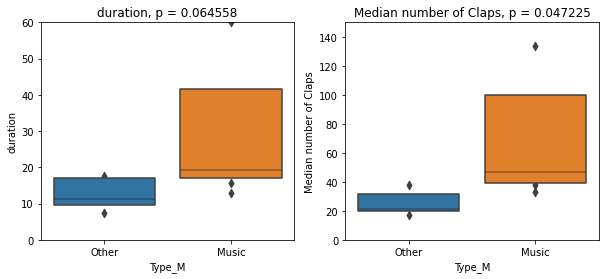

Median L ICI P Median
   Source  ddof1      ddof2         F     p-unc       np2
0  Type_M      1  10.212277  5.775109  0.036638  0.294773
LeveneResult(statistic=0.11904761904764924, pvalue=0.7360419681084175)
Median L ICI P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  8.716354  1.064786  0.329906  0.079513
LeveneResult(statistic=0.017191529664115187, pvalue=0.897855709762455)
STD L ICI P Median
   Source  ddof1    ddof2         F     p-unc       np2
0  Type_M      1  5.85471  0.039769  0.848678  0.004307
LeveneResult(statistic=0.06018291918488295, pvalue=0.8103523191131248)
STD L ICI P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  6.191381  6.991351  0.037209  0.420862
LeveneResult(statistic=0.20494125706920638, pvalue=0.6588373502309437)


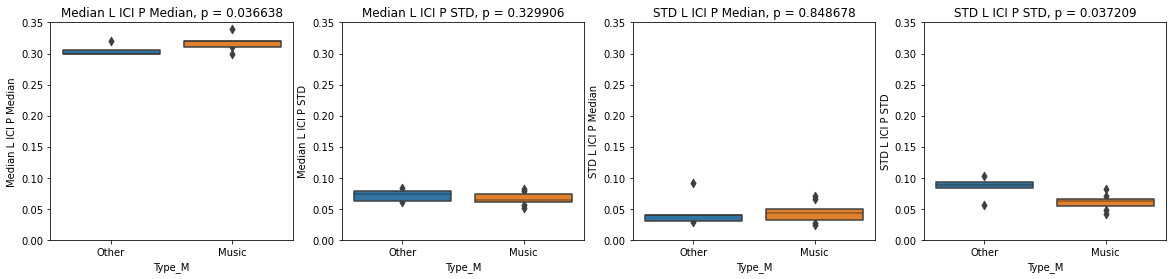

Starting L ICI P Median
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  7.872814  0.437793  0.527077  0.036717
LeveneResult(statistic=0.5274725274725179, pvalue=0.481598068920561)
Starting L ICI P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  9.166241  0.988614  0.345603  0.071869
LeveneResult(statistic=0.005920003582821263, pvalue=0.9399380144346466)


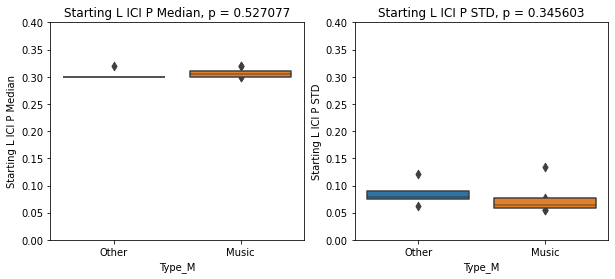

5s ICI Median P Median
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  5.969555  0.030858  0.866364  0.003292
LeveneResult(statistic=0.03963666391411674, pvalue=0.8455261225122075)
5s ICI Median P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  4.682614  3.062064  0.144506  0.290626
LeveneResult(statistic=3.0449998145894255, pvalue=0.10651591155782228)
5s ICI Quart P Median
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  4.166163  4.901669  0.088525  0.428038
LeveneResult(statistic=7.908468485966364, pvalue=0.01568527282608413)
5s ICI Quart P STD
   Source  ddof1     ddof2         F     p-unc      np2
0  Type_M      1  4.543707  3.702299  0.118114  0.33841
LeveneResult(statistic=5.6146116683478065, pvalue=0.03543255012741431)


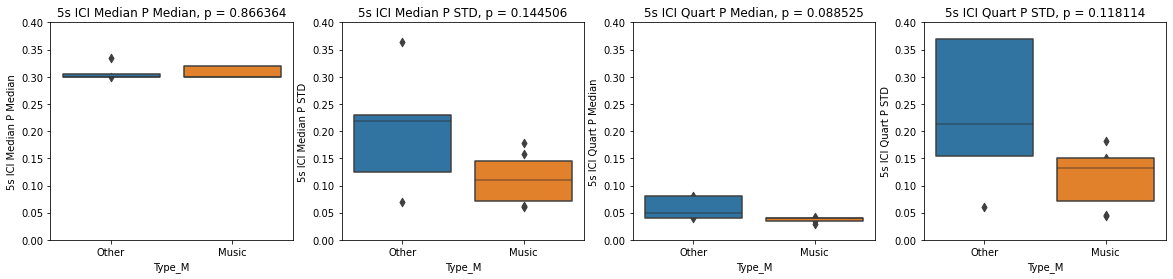

5-10s ICI Median P Median
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  7.541747  0.516822  0.493869  0.044322
LeveneResult(statistic=0.0015416238437827333, pvalue=0.9693259593724125)
5-10s ICI Median P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  6.108531  2.899771  0.138605  0.233521
LeveneResult(statistic=0.9082967912965675, pvalue=0.3593703552800377)
5-10s ICI Quart P Median
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  4.636276  4.076923  0.103927  0.355345
LeveneResult(statistic=1.7888198757764657, pvalue=0.20586821185737877)
5-10s ICI Quart P STD
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  8.515261  6.468454  0.032893  0.347818
LeveneResult(statistic=0.0584010924808604, pvalue=0.8131214224778367)


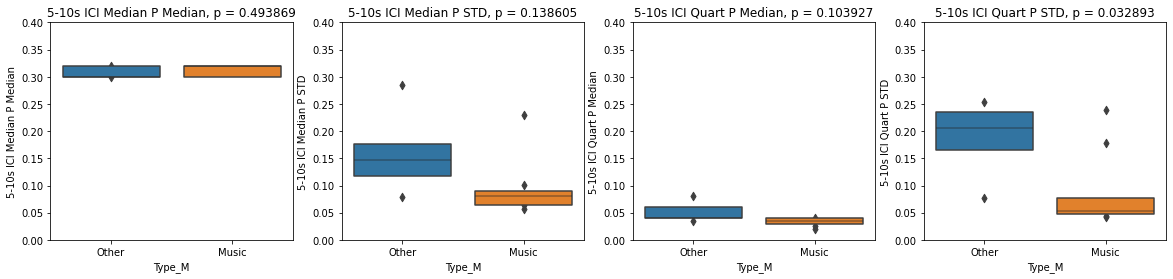

First clap P Quart
   Source  ddof1     ddof2         F     p-unc       np2
0  Type_M      1  4.046085  2.337212  0.200248  0.270137
LeveneResult(statistic=6.2007003579237345, pvalue=0.02842582137620353)
Last clap P Quart
   Source  ddof1     ddof2         F    p-unc       np2
0  Type_M      1  6.555408  0.102961  0.75829  0.010134
LeveneResult(statistic=0.5893765611739975, pvalue=0.4575011433719919)


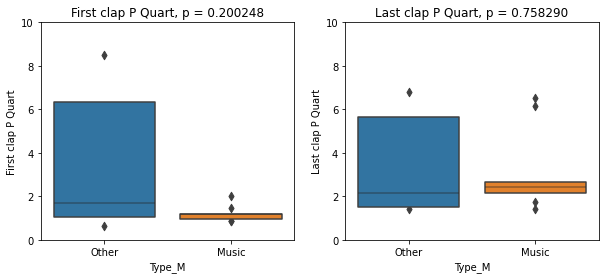

In [564]:
test_feats = [['duration', 'Median number of Claps'],
# ICI stats on variable length clapping intervals is hard to interpret
             ['Median L ICI P Median','Median L ICI P STD','STD L ICI P Median','STD L ICI P STD'],
# starting Local ICI (8s) gives a comparable view of the initial texture differences
             ['Starting L ICI P Median','Starting L ICI P STD'], # ,'Starting L ICI Quart P Mean' quartile too rough to evaluate differences on
# 5 s ICI stats tell the same story as the smoothed initial local ICI: 
    # not so different between types in clapping rate central tendency, but accross participants, the rates are significantly more consistent for music
              ['5s ICI Median P Median','5s ICI Median P STD','5s ICI Quart P Median','5s ICI Quart P STD'],
              ['5-10s ICI Median P Median','5-10s ICI Median P STD','5-10s ICI Quart P Median','5-10s ICI Quart P STD'],
    # time to first clap tends to be fast for music, but speachs vary a lot, so not clear distinction.
    # time to last clap tends to be longer too for music,
    # but this may be related to the longer clapping interval and some less clear clues for ending
              ['First clap P Quart','Last clap P Quart']]

v_range = {'duration':[0,60],'Median number of Claps':[0,150],
           'Median L ICI P Median':[0.0,0.35],'Median L ICI P STD':[0.0,0.35],'STD L ICI P Median':[0.0,0.35],'STD L ICI P STD':[0.0,0.35],
           'Starting L ICI P Median':[0.0,0.4],'Starting L ICI P STD':[0.0,0.4],'Starting L ICI Quart P Mean':[0.0,0.4],
           '5s ICI Median P Median':[0.0,0.4],'5s ICI Median P STD':[0.0,0.4],
           '5s Med ICI Median':[0.0,0.4], '5s Med ICI STD':[0.0,0.4],
           '5s ICI Quart P Median':[0.0,0.4], '5s ICI Quart P STD':[0.0,0.4],
           '5-10s ICI Median P Median':[0.0,0.4],'5-10s ICI Median P STD':[0.0,0.4],
           '5-10s ICI Quart P Median':[0.0,0.4], '5-10s ICI Quart P STD':[0.0,0.4],
           'First clap P Quart':[0.0,10], 'Last clap P Quart':[0.0,10]}

sub_ints = Applause_ints.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,14],:]

for vs in test_feats:
    f, a = plt.subplots(1,len(vs),figsize=(5*len(vs),4)) 
    for i in range(len(vs)):
        ax_i = a[i]
        v = vs[i]
        aov = pg.welch_anova(dv=v, between = 'Type_M', data = sub_ints)
        print(v)
        print(aov)

        sns.boxenplot(x = 'Type_M',y = v, data = sub_ints,ax = ax_i)
        ax_i.set_title(v + ', p = ' + "{:.6f}".format(aov['p-unc'].values[0]))
        ax_i.set_ylim(v_range[v])

        
#         group1 = sub_ints.loc[sub_ints['Type']=='Entrance',v].values
#         group2 = sub_ints.loc[sub_ints['Type']=='Speech',v].values
#         group2 = sub_ints.loc[sub_ints['Type']=='Music',v].values
        group1 = sub_ints.loc[sub_ints['Type_M']=='Other',v].values
        group2 = sub_ints.loc[sub_ints['Type_M']=='Music',v].values
        s = sp.stats.levene(group1, group2, center='median') #https://www.statology.org/brown-forsythe-test-in-python/
        print(s)
    plt.savefig('plots/clapping_m_types_stats_'+vs[0]+'_set.png',dpi = 400)
    plt.show()

When evaluating these summary applause statistics per interval with a one-way anova that allows for unequal variance (Welch), the things being applauded seem to be a significant factor for:  * p<.05, ** p<.01, *** p<.001. Test for difference in variance (Levene...)
Notes: These are very small samples, so only big effects can be caught. 

    - Median number of Claps*, which is proportional to applause duration
    - The median clapping rate*, Music conditions tends to be a bit slower, which may be an artifact of the duration of the applause intervals. Indeed, there was not measurable systematic difference in initial clapping rates for music and non music rounds (5s ICI Median P Median)
    - Variation in variability: STD L ICI STD* and 5-10s ICI Quart P STD* significantly higher across other than Music condition. There tends to be more variance across participants in their variance of local ICI for non-music applause intervals. Meaning participants are less stable in the clapping rates initially, even if they tending to similar rates. Some of this uncertainty may be due to slow starts to entrance applause rounds. The variability in initial variability between is non-music instances was also signiciantly larger than across the music pieces (Brown-Forsyth test of unequal variance for 5s ICI Quart P Median*, 5s ICI Quart P STD*). The variation in starting time is also much greater across non-music rounds of applause (Brown-Forsyth test of unequal variance on First clap P Quart*).
    
These results suggest that there is a difference in the stability of participants claps that depends on what they are clapping for, and that this difference is more pronounced at the begining of an interval of applause. 

A stronger test of this behaviour would be to allow participants contributions to be recognised and balanced in a repeated measures design.

In [565]:
Applause_ints

,start_time,end_time,duration,start_datetime,Type,Type_M,Texture,event_tag,Applause_N,cue_start_time,...,5s ICI Median P Median,5s ICI Median P STD,5s ICI Quart P Median,5s ICI Quart P STD,5-10s ICI Median P Median,5-10s ICI Median P STD,5-10s ICI Quart P Median,5-10s ICI Quart P STD,First clap P Quart,Last clap P Quart
0,-691.20,-674.1,17.10,2021-10-26 17:36:34.800,Entrance,Other,Independent,Entre 1,1,-692.20,...,0.300,0.219397,0.0500,0.213800,0.30,0.078789,0.035,0.077724,1.68,2.14
1,-555.90,-548.6,7.30,2021-10-26 17:38:50.100,Speech,Other,Independent,Speech 1,2,-556.10,...,0.300,0.069449,0.0400,0.061169,0.30,0.146490,0.040,0.164836,0.62,1.44
2,30.60,40.1,9.50,2021-10-26 17:48:36.600,Speech,Other,Independent,Speech 2,3,31.00,...,0.300,0.124594,0.0400,0.155167,0.32,0.176074,0.040,0.206245,1.06,1.52
3,1610.60,1652.1,41.50,2021-10-26 18:14:56.600,Music,Music,Mixed,Beethoven,4,1609.60,...,0.300,0.080040,0.0400,0.182424,0.30,0.064500,0.020,0.047390,1.20,6.18
4,2004.80,2016.1,11.30,2021-10-26 18:21:30.800,Entrance,Other,Independent,Entre 2,5,2004.80,...,0.305,0.229723,0.0800,0.370079,0.30,0.116667,0.080,0.234468,6.36,5.64
5,3282.60,3342.7,60.10,2021-10-26 18:42:48.600,Music,Music,Mixed,Schnittke,6,3278.90,...,0.320,0.122489,0.0350,0.085034,0.32,0.229948,0.030,0.239592,2.02,2.64
6,5001.92,5019.5,17.58,2021-10-26 19:11:27.920,Entrance,Other,Independent,Entre 3,7,5001.92,...,0.335,0.363396,0.0800,0.409498,0.32,0.284297,0.060,0.253930,8.50,6.80
7,6020.10,6042.1,22.00,2021-10-26 19:28:26.100,Music,Music,Independent,Bach,8,6017.20,...,0.320,0.157319,0.0425,0.151131,0.30,0.101886,0.040,0.178059,1.48,2.42
8,6759.10,6776.2,17.10,2021-10-26 19:40:45.100,Music,Music,Independent,Folk 1,9,6756.90,...,0.300,0.062173,0.0300,0.044461,0.30,0.090329,0.040,0.049865,1.20,2.48
9,6933.40,6952.6,19.20,2021-10-26 19:43:39.400,Music,Music,Independent,Folk 2,10,6931.90,...,0.300,0.061010,0.0400,0.071804,0.31,0.063491,0.035,0.042539,1.20,2.30


In [567]:
# assessing participant stats per work, not just summary
# note: pinguine can't deal with nan's, but can work around missing values
#claps_folder = './Data/new_indexp/clapping_peaks/'
Clapping_Indiv_stats = pd.DataFrame(index = Applause_ints.index, columns = ['Ratio clapping','Median number of Claps','STD number of Claps','Median ICI Median','Median ICI STD','STD ICI Median','STD ICI STD','Starting ICI Median','Starting ICI STD','Starting ICI Quart','5s Med ICI Median','5s Med ICI STD','5s quart ICI Median','5s quart ICI STD'])
t_interval = 1.5 # interval for ICI local assessment(half)
init_t = 5 # The time from zero (first clap) over which clapping stats are assessed for initiatory clap patterns
all_clapperings = pd.DataFrame()

for app_int in Applause_ints.index: # for each instance of clapping 
    app_type = Applause_ints.loc[app_int,'Type']
    app_Mtype = Applause_ints.loc[app_int,'Type_M']
    
    #call up the claps, convert to boolean sparse matrix with steady sample rate
    peaks = pd.read_csv(claps_folder +'clapping_peaks/' + Applause_ints.loc[app_int,'files'],index_col=0)
    df_claps = peaks.fillna(0)
    df_OnlyClaps = df_claps.astype(bool).astype(int)
    total_claps = df_OnlyClaps.sum()
    df_OnlyClaps = df_OnlyClaps.loc[:,total_claps>0]
        # first and last claps as detected, note this is sensitive to quality of detection
    a = df_OnlyClaps.ne(0).idxmax()
    first_claps = a-a.min()
    a = df_OnlyClaps.iloc[::-1].ne(0).idxmax()
    last_claps = a-a.max()
    
    clapperings = pd.DataFrame(index = df_OnlyClaps.columns)
    clapperings['Type'] = app_type
    clapperings['Type_M'] = app_Mtype
    clapperings['Instance'] = Applause_ints.loc[app_int,'Applause_N'] 
    clapperings['Time'] = Applause_ints.loc[app_int,'start_time'] 

    clapperings['Event_tag'] = Applause_ints.loc[app_int,'event_tag']
    clapperings['Participant'] = clapperings.index
    
    clapperings['Clap_Count'] = total_claps[total_claps>0]

    # assess local ICIs 
    sampletimes = np.arange(0,df_OnlyClaps.index[-1]-5,0.5)
    Clap_Feats = pd.DataFrame(index = sampletimes,columns = df_OnlyClaps.columns)
    for samp in range(len(sampletimes)):
        t_0 = sampletimes[samp]
        sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
#         clap_stats = []
        cols = sub_claps.columns
        these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
        for partn in cols:
            ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
            if ici.notna().sum()>1:
                these_claps[partn]=np.nanmedian(ici)
        Clap_Feats.loc[t_0,:] = these_claps
     
    clapperings['ICI Median'] = Clap_Feats.median()
    clapperings['Average Rate'] = 60/Clap_Feats.mean() # in BPM
    clapperings['ICI STD'] = Clap_Feats.std()
    clapperings['ICI in quarts'] = (Clap_Feats.astype(float).quantile([0.75]).values-Clap_Feats.astype(float).quantile([0.25]).values)[0] # quartile by time, not by clap
    clapperings['Rel_firstclap']=first_claps
    clapperings['Rel_lastclap']=last_claps
    
    # looking at first 
    sub_claps = df_OnlyClaps.loc[:init_t,:] # Excerpt of claps
#         clap_stats = []
    cols = sub_claps.columns
    these_claps = pd.Series(index = df_OnlyClaps.columns,dtype='float64')
    these_claps_med = these_claps.copy()
    these_claps_quart = these_claps.copy()
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_claps_med[partn]=np.nanmedian(ici)
            these_claps_quart[partn]=np.nanquantile(ici,[0.75])-np.nanquantile(ici,[0.25])
    clapperings['Initial ICI Median'] = these_claps_med
    clapperings['Initial ICI in quarts'] = these_claps_quart    

    all_clapperings = pd.concat([all_clapperings,clapperings],ignore_index=True)
    
#all_clapperings

In [568]:
str(aov['p-unc'].values[0])

'0.7582901671811775'

Clap_Count
         Source         W     ddof1       ddof2            F          p-unc
Friedman   Type  0.975016  1.974359  152.025641  3005.026316  1.492472e-122


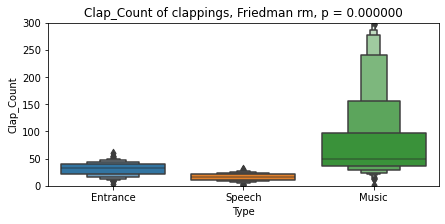

ICI Median
         Source         W     ddof1       ddof2         F     p-unc
Friedman   Type  0.154011  1.974359  152.025641  14.01768  0.000003


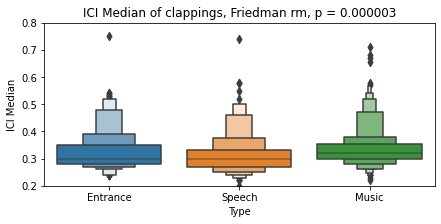

Average Rate
         Source         W     ddof1       ddof2          F     p-unc
Friedman   Type  0.130342  1.974359  152.025641  11.540541  0.000024


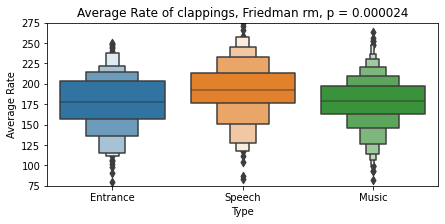

ICI STD
         Source         W     ddof1       ddof2         F     p-unc
Friedman   Type  0.107988  1.974359  152.025641  9.321725  0.000163


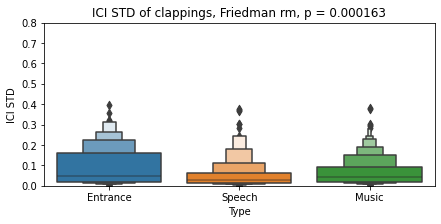

ICI in quarts
         Source         W     ddof1       ddof2         F     p-unc
Friedman   Type  0.090894  1.974359  152.025641  7.698608  0.000691


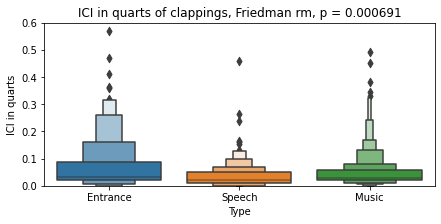

Initial ICI Median
         Source         W     ddof1       ddof2         F     p-unc
Friedman   Type  0.072863  1.972973  144.027027  5.737049  0.004167


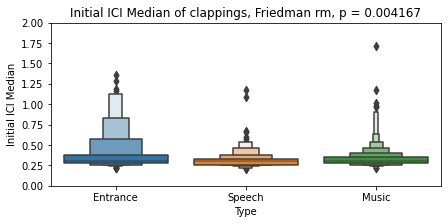

Initial ICI in quarts
         Source         W     ddof1       ddof2         F     p-unc
Friedman   Type  0.085464  1.972973  144.027027  6.821885  0.001552


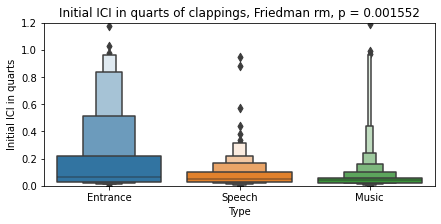

Rel_firstclap
         Source         W     ddof1       ddof2         F         p-unc
Friedman   Type  0.202334  1.974359  152.025641  19.53163  3.298721e-08


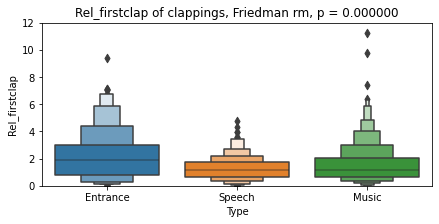

Rel_lastclap
         Source         W     ddof1       ddof2          F         p-unc
Friedman   Type  0.445266  1.974359  152.025641  61.805333  3.343026e-20


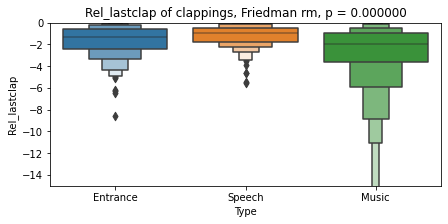

In [569]:
v_range = {'Clap_Count':[0,300], 'ICI Median':[0.2,0.8], 'Average Rate':[75,275], 'ICI STD':[0.0,0.8], 'ICI in quarts':[0.0,0.6],
       'Initial ICI Median':[0.0,2.0], 'Initial ICI in quarts':[0.0,1.2],'Rel_firstclap':[0.0,12],'Rel_lastclap':[-15.0,0]}
for v in ['Clap_Count', 'ICI Median', 'Average Rate', 'ICI STD', 'ICI in quarts',
       'Initial ICI Median', 'Initial ICI in quarts','Rel_firstclap','Rel_lastclap']:
    aov = pg.friedman(dv=v, within = 'Type',subject='Participant',method='f',data = all_clapperings )
    print(v)
    print(aov)
    f, a = plt.subplots(1,1,figsize=(7,3)) 
    sns.boxenplot(x = 'Type',y = v, data = all_clapperings,ax = a)
    plt.title(v + ' of clappings, Friedman rm, p = ' + "{:.6f}".format(aov['p-unc'].values[0]))
    plt.savefig('plots/clappings_'+v+'_rm_Type.png',dpi = 300)
    plt.ylim(v_range[v])
    plt.show()


To further test for differences in how participants applaud given what they are applauding to (Type), we use the non-parametric Friedman test with repeated measures on individual participant clapping sequences (* p<.05, ** p<.01, *** p<.001). The results support strongly significant difference between clapping prompts.

    - Clap_Count*** the number of claps counted given event type was very strong, as expected, given the differences in applause durations. 
    - Median*** and Average Rate*** (BPM): Even though the averages across participants are very close across types, repeated measures exposes an effect of type, with speech the fastest. Is this again a length effect? 
    - ICI STD** and ICI in quarts*** seperate the three categories the most. The shortness of Speech segments keep it relatively low in median and dispersion, with Music next and then Entrance with highest variability.
    - Initial ICI Median** and Initial ICI in quarts* shows this clearly, with Speech and Music keeping it tight and Entrance tending to spread, as well as wider Rel_firstclap***
     

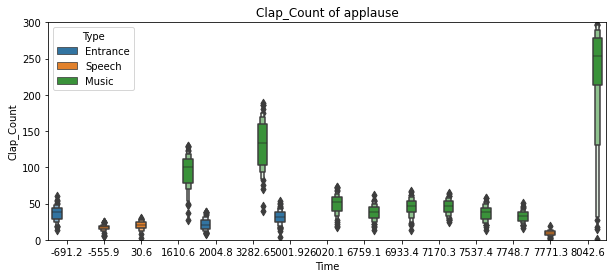

         Source         W     ddof1       ddof2            F          p-unc
Friedman   Type  0.975016  1.974359  152.025641  3005.026316  1.492472e-122


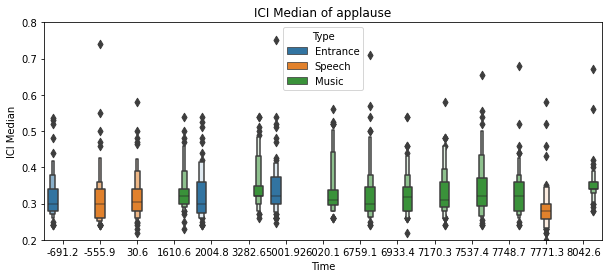

         Source         W     ddof1       ddof2         F     p-unc
Friedman   Type  0.154011  1.974359  152.025641  14.01768  0.000003


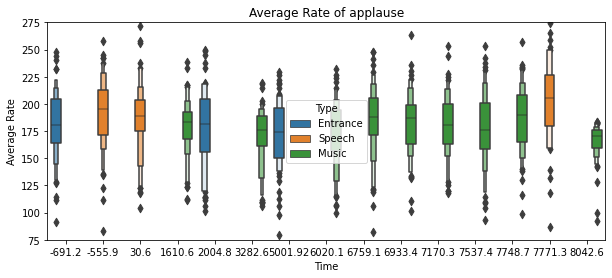

         Source         W     ddof1       ddof2          F     p-unc
Friedman   Type  0.130342  1.974359  152.025641  11.540541  0.000024


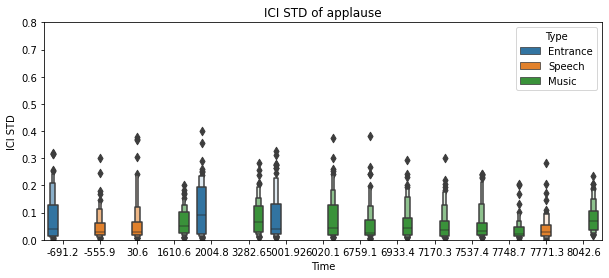

         Source         W     ddof1       ddof2         F     p-unc
Friedman   Type  0.107988  1.974359  152.025641  9.321725  0.000163


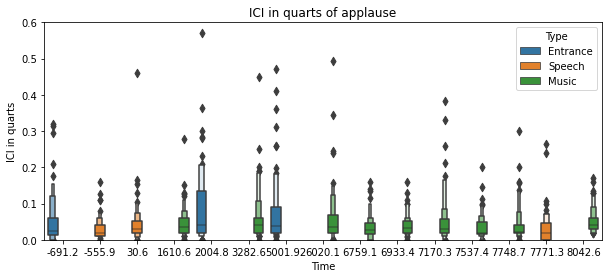

         Source         W     ddof1       ddof2         F     p-unc
Friedman   Type  0.090894  1.974359  152.025641  7.698608  0.000691


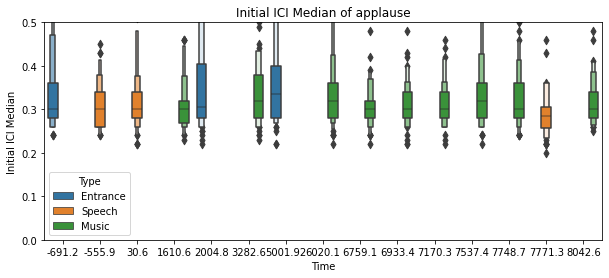

         Source         W     ddof1       ddof2         F     p-unc
Friedman   Type  0.072863  1.972973  144.027027  5.737049  0.004167


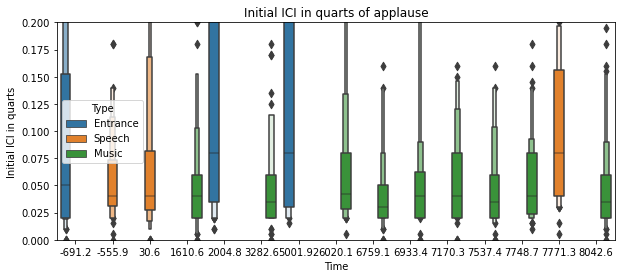

         Source         W     ddof1       ddof2         F     p-unc
Friedman   Type  0.085464  1.972973  144.027027  6.821885  0.001552


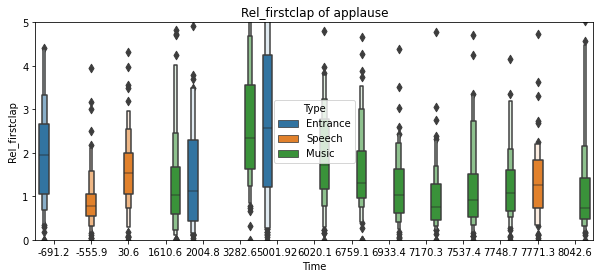

         Source         W     ddof1       ddof2         F         p-unc
Friedman   Type  0.202334  1.974359  152.025641  19.53163  3.298721e-08


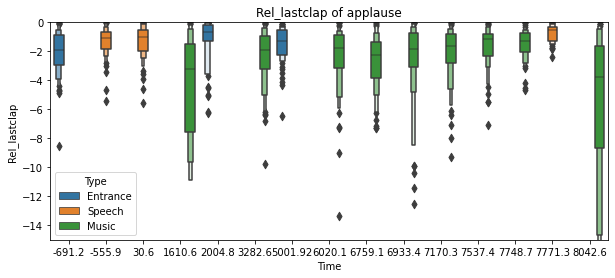

         Source         W     ddof1       ddof2          F         p-unc
Friedman   Type  0.445266  1.974359  152.025641  61.805333  3.343026e-20


In [570]:
v_range = {'Clap_Count':[0,300], 'ICI Median':[0.2,0.8], 'Average Rate':[75,275], 'ICI STD':[0.0,0.8], 'ICI in quarts':[0.0,0.6],
       'Initial ICI Median':[0.0,0.5], 'Initial ICI in quarts':[0,0.2],'Rel_firstclap':[0.0,5],'Rel_lastclap':[-15.0,0]}
for v in ['Clap_Count', 'ICI Median', 'Average Rate', 'ICI STD', 'ICI in quarts',
       'Initial ICI Median', 'Initial ICI in quarts','Rel_firstclap','Rel_lastclap']:
    
    f, a = plt.subplots(1,1,figsize=(5*len(vs),4)) 

    sns.boxenplot(x = 'Time', hue = 'Type',y = v, data = all_clapperings,ax=a)
    plt.title(v + ' of applause')
    plt.ylim(v_range[v])
    plt.savefig('plots/applause_feats_allclaps_'+v+'.png',dpi = 400)
    plt.show()
    aov = pg.friedman(dv=v, within = 'Type',subject='Participant',method='f',data = all_clapperings )
    print(aov)

## Characterising last applause

In [571]:
# note these time are approximate to around the second, aligned roughly to final clapping excerpt times 
# Should be confirmed with better video interface than youtube
musician_times = pd.read_csv('./Data/Final_clapping_section_accelerometer/Final_Stage_events.csv',sep=",") #SV alignment for beeps
thisround = applause_times.loc[applause_times['Applause_N']==15,:].reset_index(drop=True)
# TIME LABEL
musician_times = pd.DataFrame()
musician_times['TIME'] = thisround.loc[1:,'concert_time']-thisround.loc[thisround['Event']=='Clapping Start','concert_time'].values#+25
musician_times['LABEL'] = thisround['Event']
musician_times

,TIME,LABEL
1,-1.3,Last note
2,0.0,Clapping Start
3,0.0,Musicians start to stand
4,1.0,Musicians all standing
5,4.0,Bow 1
6,11.0,Bow 2
7,17.0,Turn for de-equip
8,19.0,Claps begin to sync
9,19.0,De-equiping
10,23.2,Claps in synch


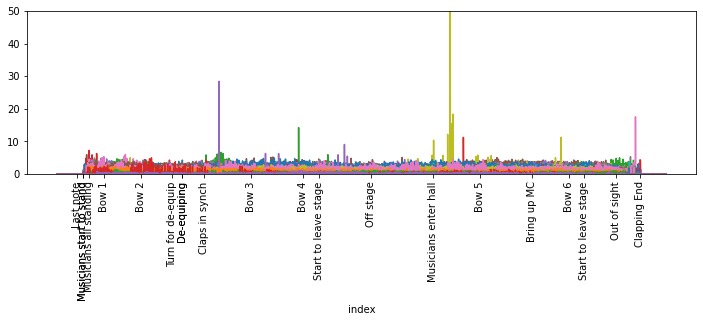

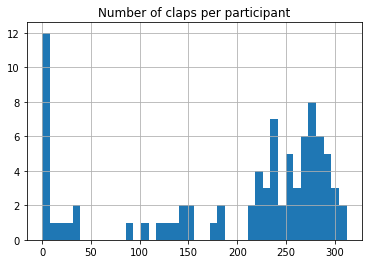

In [601]:
peaks = pd.read_csv(claps_folder +'clapping_peaks/' + Applause_ints.loc[14,'files'],index_col=0)
#peaks = pd.read_csv(claps_folder + '/final_peaks.csv',index_col=0)
df_claps = peaks.fillna(0)
df_claps.plot(figsize = [12,3],legend = False)
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation='vertical')
#plt.xticks(musician_times.datetime,musician_times.Event, rotation='vertical')
plt.ylim([0,50])
plt.show()

# drop the clap amplitude for simpler analysis and count claps per participant
df_OnlyClaps = df_claps.astype(bool).astype(int)
df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant')
plt.show()

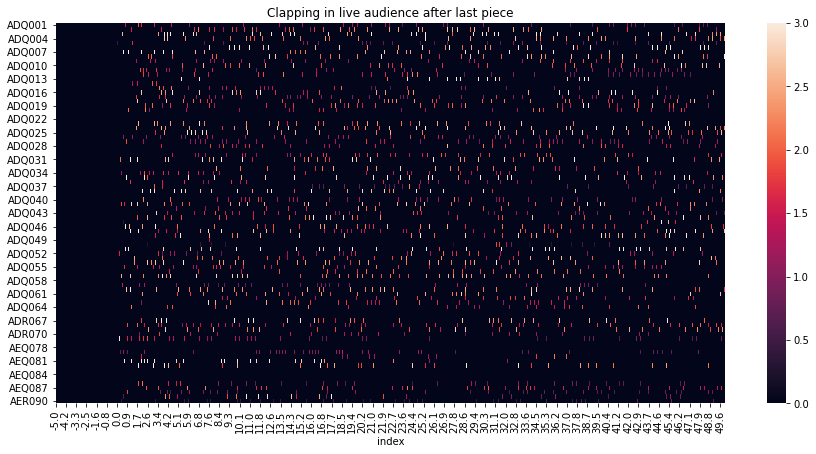

In [602]:
fig, ax = plt.subplots(figsize = [15,7])
chart = sns.heatmap(data=df_claps.loc[:50,:].transpose(), ax=ax,vmin=0, vmax=3)

plt.title('Clapping in live audience after last piece')
ax.set_xticklabels([])
ax.set_xticklabels(np.round(0+df_claps.iloc[ax.get_xticks()].index,1))
#plt.savefig('claps_finale_indiv.png',dpi=800)
plt.show()

# this visualisation does not necessarily show all claps, nor is it easy to interpret their alignment.
# use activity levels instead.

Median time to start clapping: 0.58s
Inner quartile range: 0.94s


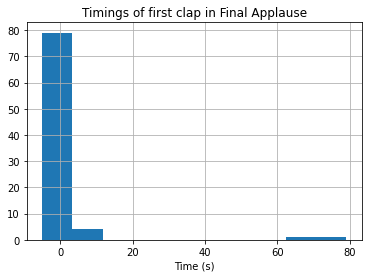

In [603]:
# Time to first clap.
first_claps =df_claps.ne(0).idxmax()
fig = first_claps.hist()
plt.xlabel('Time (s)')
plt.title('Timings of first clap in Final Applause')

print('Median time to start clapping: ' + str(np.round(first_claps.median(),3)) + 's\nInner quartile range: ' + str(np.round(first_claps.quantile(0.75)-first_claps.quantile(0.25),3)) + 's')

In [604]:
# build database of clapping stats over measured intervals
Clap_Style = pd.DataFrame(columns = ['Interval_start','Interval_duration','Interval_condition','Participant','ICI_Median','ICI_Quartiles','ICI_Mean','ICI_STD','Clap_Count'])
t_interval = 3
#sampletimes = np.array([10, 14, 18, 20, 35, 50, 65, 80, 104,108,112]) # sampletimes-5
sampletimes = np.array([3, 8, 12, 13, 28, 35, 44, 50, 78, 85, 90,100])
sampleconditions = ['Initial','Initial','Initial','Initial','Synched','Synched','Synched','Synched','End','End','End','End']
for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    t_con = sampleconditions[samp]
    sub_claps = df_OnlyClaps.loc[t_0:t_0+t_interval,:] # Excerpt of claps
    clap_stats = []
    cols = sub_claps.columns
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index).diff()
        #if len(ici)>0:
        these_claps = {'Interval_start':t_0, 'Interval_duration':t_interval, 'Interval_condition':t_con,
           'Participant':partn, 'ICI_Median':np.nan, 'ICI_Quartiles':np.nan, 
           'ICI_Mean':np.nan, 'ICI_STD':np.nan, 'Clap_Count':len(ici)}
        if len(ici)>3:
            these_claps = {'Interval_start':t_0, 'Interval_duration':t_interval, 'Interval_condition':t_con,
           'Participant':partn, 'ICI_Median':ici.median(), 'ICI_Quartiles':np.round(ici.quantile(q=0.75,interpolation='nearest')-ici.quantile(q=0.25,interpolation='nearest'),5), 
           'ICI_Mean':ici.mean(), 'ICI_STD':ici.std(), 'Clap_Count':len(ici)}    
        clap_stats.append(these_claps)
    Clap_Style = pd.concat([Clap_Style, pd.DataFrame(clap_stats)], ignore_index=True)
    
# to_numeric
cols = ['ICI_Mean','ICI_Median','ICI_Quartiles','ICI_STD']
for c in cols:
    Clap_Style.loc[:,c] = pd.to_numeric(Clap_Style[c])

In [605]:
# clear out nans in case they make the functions panic
cstats = Clap_Style.where(Clap_Style['Clap_Count']>0)
cstats = cstats.dropna()

In [606]:
Clap_Style['ICI_Median'].sum()

261.67000000000024

ICI_Median
                      Source      W  ddof1    ddof2      F  p-unc
Friedman  Interval_condition  0.094  1.968  122.032  6.431  0.002


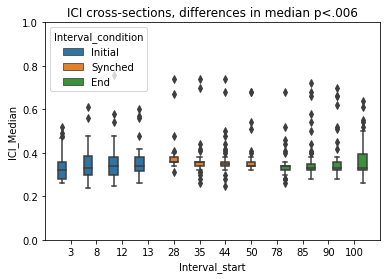


ICI_Quartiles
                      Source      W  ddof1    ddof2       F  p-unc
Friedman  Interval_condition  0.146  1.968  122.032  10.595    0.0


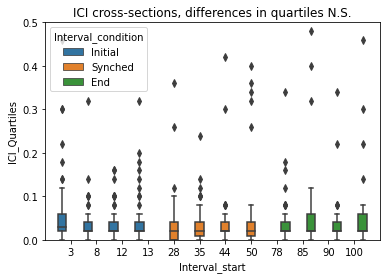

In [607]:
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Median', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print('ICI_Median')
print(aov.round(3))
sns.boxplot(x = "Interval_start",y="ICI_Median",hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,1])
plt.xlim([-1,12])
plt.title('ICI cross-sections, differences in median p<.006')
plt.savefig('Intervals_Xsec_Medians.png',dpi=400)

plt.show()
#https://pingouin-stats.org/generated/pingouin.friedman.html#pingouin.friedman
aov = pg.friedman(dv='ICI_Quartiles', within='Interval_condition',
                  subject='Participant', method = 'f',data=Clap_Style)
print('\nICI_Quartiles')
print(aov.round(3))
sns.boxplot(x = "Interval_start",y='ICI_Quartiles',hue = 'Interval_condition',width = 1,data = Clap_Style)
plt.ylim([0,0.5])
plt.xlim([-1,12])
plt.title('ICI cross-sections, differences in quartiles N.S.')
plt.savefig('Intervals_Xsec_Quartiles.png',dpi=400)
plt.show()

This demonstrates that the clapping does seem to change in rate marginally for some applause periods, and there is a visible change in variance across participants during the synchronous clapping interval, however there is no measured difference in variability in individuals clapping over this interval.

This means that prior to synchronisation, individuals clapping sequences were comparably stable or isochronous. Clapping together did not improve the regularity of the audience participants claps *according to the precision of these measurements* with a sample rate of 20 ms, very coarse for this kind of analysis. 

# Shift into synchrony
The alignment of the measurements is not quite high enough to evaluate synchronisation with phase presevered. To facilitate the identification of the transition to coordinated claping, we use instead the local median interclapinterval: the predominant interval between claps in a sliding window of 3 secondes, to capture the regularity despite fleeting outliers and deviations. 

We use the interclap interval instead of rate to simplify some manipulations. 

In [610]:
peaks = pd.read_csv(claps_folder +'clapping_peaks/' + Applause_ints.loc[14,'files'],index_col=0)
# peaks = pd.read_csv(claps_folder + 'Applause_15_finale_peaks.csv',index_col=0)
df_claps = peaks.fillna(0)
df_OnlyClaps = df_claps.astype(bool).astype(int)

In [611]:
(df_OnlyClaps.sum()>50).sum() # there should over 65 series with ICI feature values

68

In [612]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0,106.9-t_interval,0.5)
cols = df_OnlyClaps.columns
Clap_Feats = pd.DataFrame(index = sampletimes,columns = cols)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    these_claps = pd.Series(index = cols,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0,:] = these_claps
Clap_Feats.loc[25:30]

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ086,AEQ087,AEQ088,AEQ089,AER090
25.0,0.37,0.33,0.37,0.38,0.38,0.4,0.38,0.38,0.38,0.38,...,0.3,0.36,NaN,NaN,NaN,0.34,0.4,0.36,NaN,0.4
25.5,0.36,0.34,0.36,0.38,0.38,0.39,0.38,0.38,0.38,0.38,...,0.3,0.39,NaN,NaN,NaN,0.34,0.38,0.36,NaN,0.38
26.0,0.36,0.34,0.36,0.38,0.36,0.38,0.38,0.38,0.38,0.37,...,0.34,0.38,NaN,NaN,NaN,0.34,0.38,0.36,NaN,0.4
26.5,0.36,0.34,0.36,0.38,0.37,0.36,0.38,0.37,0.38,0.36,...,0.36,0.37,NaN,NaN,NaN,0.33,0.36,0.36,NaN,0.41
27.0,0.36,0.38,0.36,0.38,0.37,0.36,0.36,0.36,0.38,0.36,...,NaN,0.38,NaN,NaN,NaN,0.34,0.38,0.36,NaN,0.38
27.5,0.36,0.38,0.36,0.36,0.36,0.36,0.38,0.36,0.38,0.36,...,NaN,0.36,NaN,NaN,NaN,0.34,0.36,0.36,NaN,0.38
28.0,0.36,0.37,0.36,0.38,0.37,0.36,0.36,0.36,0.38,0.36,...,NaN,0.36,NaN,NaN,NaN,0.34,0.36,0.36,NaN,0.38
28.5,0.36,0.36,0.36,0.38,0.37,0.37,0.36,0.36,0.38,0.36,...,NaN,0.36,NaN,NaN,NaN,0.34,0.36,0.38,NaN,0.38
29.0,0.36,0.36,0.35,0.38,0.36,0.38,0.36,0.36,0.36,0.37,...,NaN,0.36,NaN,NaN,NaN,0.34,0.36,0.38,NaN,0.36
29.5,0.36,0.36,0.34,0.38,0.36,0.38,0.36,0.36,0.36,0.38,...,NaN,0.36,NaN,NaN,NaN,0.34,0.36,0.38,0.48,0.38


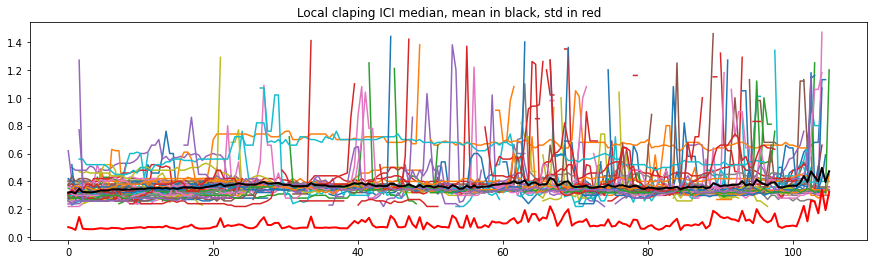

In [613]:
# to get an idea of what values these take
Clap_Feats.plot(legend=False,figsize=[15,4])
plt.title('Local claping ICI median, mean in black, std in red')
B = Clap_Feats.mean(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.show()

The protruding lines show how many participants start a clapping sequences with a solo clap before getting into a stead rate. Also visible here is thea few people clapping at half the rate of the audience once a common rate has been established. Very neet. 

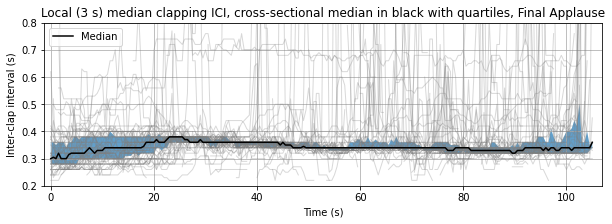

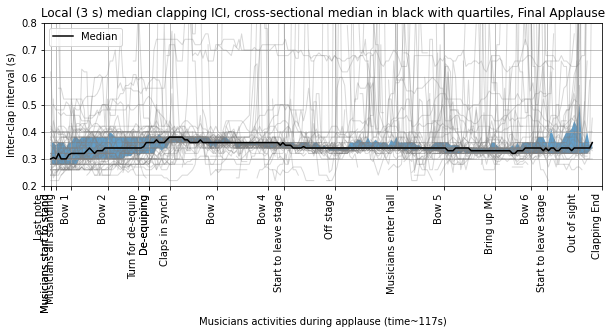

In [614]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

#df_feats.loc[:10]

fig,ax = plt.subplots(1,1,figsize=[10,3])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.xlim([-1.3,106.9])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles, Final Applause')
plt.savefig('FinalApplause_Local_ICI_medians_QuartileTS.png',bbox_inches = 'tight',dpi=300)
plt.show()



fig,ax = plt.subplots(1,1,figsize=[10,3])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.xlim([-1.3,106.9])
plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation=90, ha='right')
plt.grid()
plt.xlabel('Musicians activities during applause (time~117s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles, Final Applause')
plt.savefig('FinalApplause_Local_ICI_medians_QuartileTS_MusEv.png',bbox_inches = 'tight',dpi=300)
plt.show()

<AxesSubplot:>

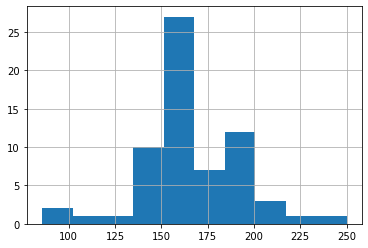

In [615]:
(60/Clap_Feats.loc[20]).hist()

<AxesSubplot:>

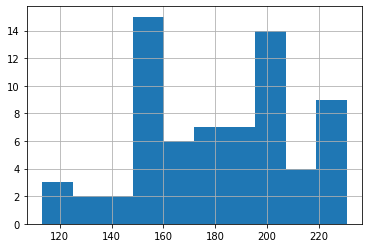

In [616]:
(60/Clap_Feats.loc[8]).hist()

<AxesSubplot:>

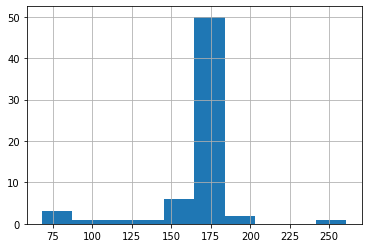

In [617]:
(60/Clap_Feats.loc[40]).hist()

<AxesSubplot:>

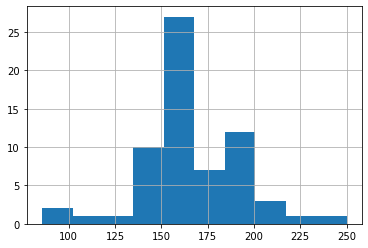

In [618]:
(60/Clap_Feats.loc[20]).hist()

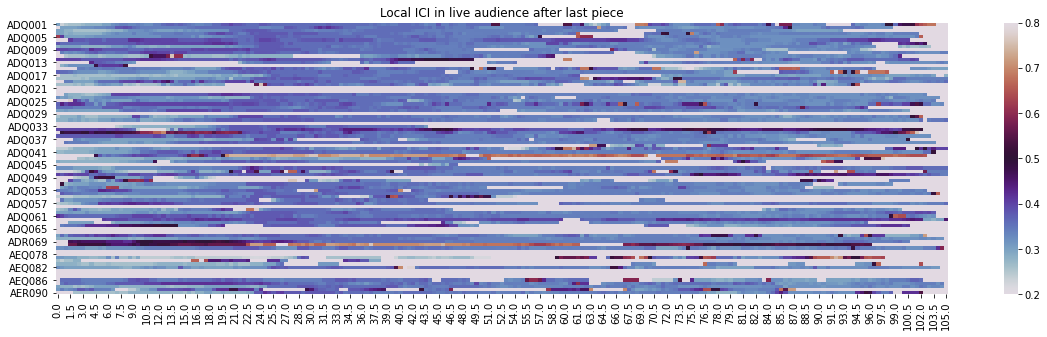

In [619]:
# now to show these as individual sequences
df_A = Clap_Feats.copy()
df_A.fillna(0,inplace=True)
fig, ax = plt.subplots(figsize = [20,5])
chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.2, vmax=0.8,cmap='twilight')

plt.title('Local ICI in live audience after last piece')
ax.set_xticklabels(np.round(df_A.iloc[ax.get_xticks()].index,2))
#plt.savefig('claps_finale_heatRough.png')
plt.show()


73


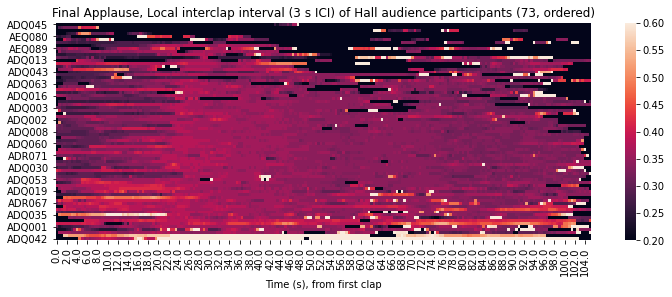

In [620]:
# now to show these as individual sequences
# sorted by distance from the median local ICI time series across audience, not absolute
#cm = plt.cm.get_cmap('twilight')
# df.filter(like='bbi', axis=0)

feat_set = Clap_Feats.copy()
feat_set.fillna(0,inplace=True)
feat_set = feat_set.loc[:,feat_set.sum()>1] # take out the few that barely move, could be recording error.
print(len(feat_set.columns))
dists = abs(feat_set.sub(feat_set.median(axis=1),axis = 0)).sum()*np.sign(feat_set.sub(feat_set.median(axis=1),axis = 0).sum())

df_A = Clap_Feats[dists.sort_values().index].copy()#*1000 # convert to milliseconds
df_A.fillna(0.01,inplace=True)
fig, ax = plt.subplots(figsize = [12,4])
chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.200, vmax=0.600)
plt.title('Final Applause, Local interclap interval (3 s ICI) of Hall audience participants (73, ordered)')
plt.xlabel('Time (s), from first clap')
ax.set_xticklabels(np.round(df_A.iloc[ax.get_xticks()].index,2))
plt.savefig('FinaleApplause_ICIheatT.png',bbox_inches = 'tight',dpi=300)
plt.show()


73


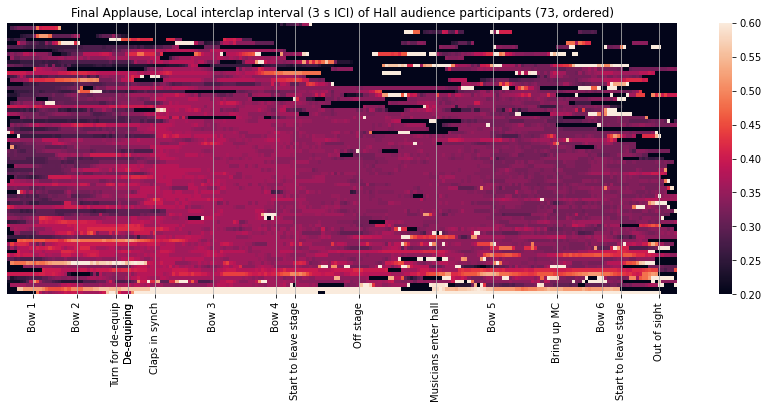

In [621]:
# now to show these as individual sequences
# sorted by distance from the median local ICI time series across audience, not absolute
#dists = Clap_Feats.sub(Clap_Feats.median(axis=1),axis = 0).sum()
feat_set = Clap_Feats.copy()
feat_set.fillna(0,inplace=True)
feat_set = feat_set.loc[:,feat_set.sum()>1] # take out the few that barely move, could be recording error.
print(len(feat_set.columns))
dists = abs(feat_set.sub(feat_set.median(axis=1),axis = 0)).sum()*np.sign(feat_set.sub(feat_set.median(axis=1),axis = 0).sum())

df_A = Clap_Feats[dists.sort_values().index].copy()#*1000 # convert to milliseconds
df_A.fillna(0.01,inplace=True)

fig, ax = plt.subplots(figsize = [15,5])
chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.200, vmax=0.600)
plt.title('Final Applause, Local interclap interval (3 s ICI) of Hall audience participants (73, ordered)')
#plt.xlabel('Time (s), from first clap')
#plt.xticks(musician_times.TIME,musician_times.LABEL, rotation=45,ha='right')
subtimes= musician_times.loc[5:20]
new_xticks = len(df_A)*(subtimes.TIME-df_A.index[0])/(df_A.index[-1]-df_A.index[0])
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
ax.set_xticks(new_xticks)
ax.set_xticklabels(subtimes.LABEL)
ax.set_yticks([])
ax.grid()
plt.savefig('FinaleApplause_ICIheatEvents.png',bbox_inches = 'tight',dpi=300)
#plt.savefig('claps_ICI_finale_heatRoughsort_ME.png')
plt.show()


# contrast with Schnittke Applause

https://youtu.be/S4UVJybA6ZQ?t=5273

In [622]:
peaks = pd.read_csv(claps_folder +'clapping_peaks/' + Applause_ints.loc[5,'files'],index_col=0)
# peaks = pd.read_csv(claps_folder + 'Applause_6_schnittke_peaks.csv',index_col=0)
peaks_IDs = peaks.columns
df_claps = peaks.fillna(0)
df_OnlyClaps = df_claps.astype(bool).astype(int)

# note these time are approximate to around the second, aligned roughly to final clapping excerpt times 
# Should be confirmed with better video interface than youtube
musician_times = pd.read_csv('./Data/Final_clapping_section_accelerometer/Final_Stage_events.csv',sep=",") #SV alignment for beeps
thisround = applause_times.loc[applause_times['Applause_N']==6,:].reset_index(drop=True)
# TIME LABEL
cl_start = thisround.loc[thisround['Event']=='Clapping Start','concert_time'].values
cl_end = thisround.loc[thisround['Event']=='Clapping End','concert_time'].values
cl_dur = cl_end - cl_start
musician_times = pd.DataFrame()
musician_times['TIME'] = thisround.loc[3:14,'concert_time']-cl_start#+25
musician_times['LABEL'] = thisround['Event']
musician_times

,TIME,LABEL
3,0.0,Clapping Start
4,2.0,Stand
5,12.0,bow
6,17.0,Start to leave stage
7,22.0,Claps in synch
8,26.0,Off stage
9,37.0,Claps in synch
10,37.0,Musicians enter hall
11,45.0,bow
12,51.0,bow


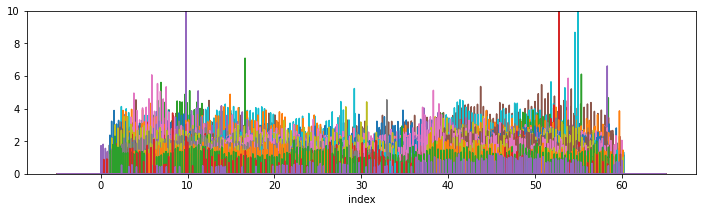

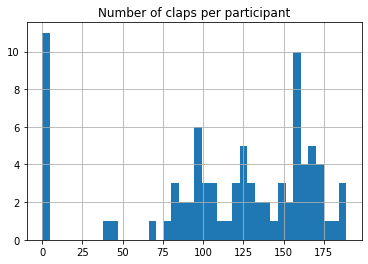

In [623]:
df_claps.plot(figsize = [12,3],legend = False)
plt.ylim([0,10])
plt.show()

# drop the clap amplitude for simpler analysis and count claps per participant
df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant')
plt.show()

In [624]:
# reduce the analysis set to only those recordings with a minimum number of claps for this interval (20).
a = df_OnlyClaps.sum().index
print([len(a),len(a[df_OnlyClaps.sum()>20])])

# reduce analysis set to only those responses with claps detected
df_claps = df_claps.loc[:,a[df_OnlyClaps.sum()>20]]
claps_ID = a[df_OnlyClaps.sum()>20] # the participant identifiers matching df_clap columns, in case of need
df_claps.columns = range(df_claps.columns.size)
df_OnlyClaps = df_claps.astype(bool).astype(int)

[85, 74]


Median time to start clapping: 2.37s
Inner quartile range: 1.93s


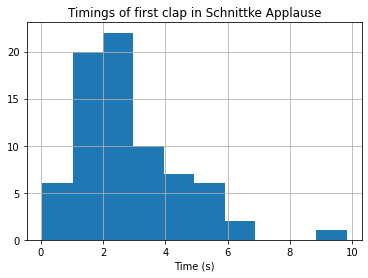

In [625]:
# Time to first clap.
first_claps =df_claps.ne(0).idxmax()
fig = first_claps.hist()
plt.xlabel('Time (s)')
plt.title('Timings of first clap in Schnittke Applause')

print('Median time to start clapping: ' + str(np.round(first_claps.median(),3)) + 's\nInner quartile range: ' + str(np.round(first_claps.quantile(0.75)-first_claps.quantile(0.25),3)) + 's')

In [626]:
last_claps =df_claps.where(df_claps!=0).last_valid_index()
last_claps

60.22

In [628]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0,cl_dur-t_interval,0.5)
cols = df_OnlyClaps.columns
Clap_Feats = pd.DataFrame(index = sampletimes,columns = cols)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    these_claps = pd.Series(index = cols,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>0:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0,:] = these_claps
Clap_Feats.loc[:5]

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0.0,NaN,0.58,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28,NaN,NaN
0.5,0.26,0.5,NaN,NaN,NaN,0.64,0.36,NaN,NaN,NaN,...,NaN,0.52,NaN,0.3,NaN,NaN,NaN,0.24,NaN,NaN
1.0,0.26,0.39,NaN,NaN,0.44,0.47,0.36,0.32,NaN,NaN,...,NaN,0.48,NaN,0.27,NaN,NaN,NaN,0.24,NaN,NaN
1.5,0.26,0.36,0.3,NaN,0.42,0.37,0.34,0.3,NaN,NaN,...,NaN,0.38,NaN,0.27,NaN,NaN,0.32,0.24,NaN,NaN
2.0,0.26,0.32,0.3,0.36,0.4,0.3,0.34,0.29,NaN,NaN,...,0.97,0.32,NaN,0.28,NaN,0.98,0.31,0.24,NaN,0.84
2.5,0.26,0.31,0.3,0.35,0.4,0.3,0.34,0.3,0.38,0.38,...,0.29,0.38,NaN,0.28,NaN,0.42,0.29,0.24,0.3,0.6
3.0,0.26,0.3,0.3,0.35,0.39,0.3,0.33,0.3,0.26,0.38,...,0.24,0.32,NaN,0.28,NaN,0.4,0.29,0.24,0.34,0.52
3.5,0.26,0.28,0.3,0.34,0.38,0.28,0.32,0.3,0.26,0.38,...,0.26,0.26,NaN,0.28,0.58,0.4,0.29,0.24,0.4,0.52
4.0,0.26,0.28,0.3,0.35,0.38,0.27,0.32,0.3,0.26,0.38,...,0.26,0.29,NaN,0.28,0.38,0.32,0.3,0.24,0.42,0.44
4.5,0.26,0.28,0.3,0.35,0.38,0.28,0.32,0.3,0.26,0.38,...,0.26,0.29,0.38,0.3,0.35,0.3,0.28,0.24,0.43,0.44


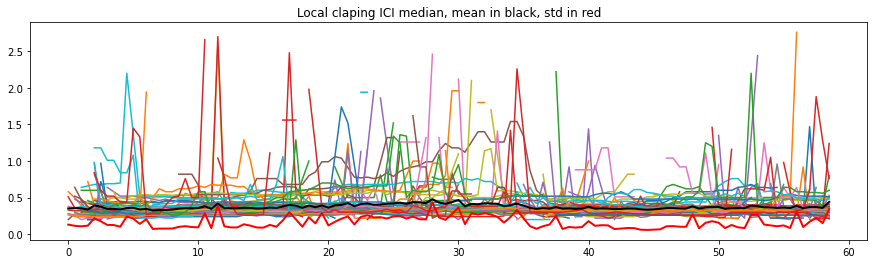

In [629]:
# to get an idea of what values these take
Clap_Feats.plot(legend=False,figsize=[15,4])
plt.title('Local claping ICI median, mean in black, std in red')
B = Clap_Feats.mean(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.show()

In [630]:
musician_times.iloc[-1,0]

60.09999999999991

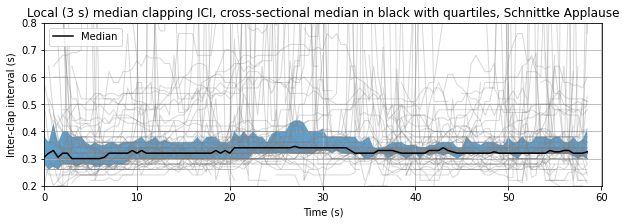

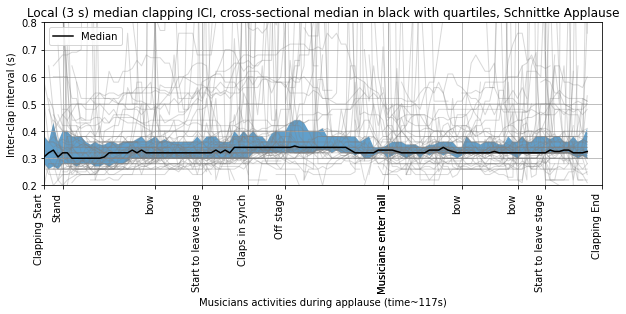

In [631]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

#df_feats.loc[:10]

fig,ax = plt.subplots(1,1,figsize=[10,3])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.xlim([0,cl_dur])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles, Schnittke Applause')
plt.savefig('SchnittkeApplause_Local_ICI_medians_QuartileTS.png',bbox_inches = 'tight',dpi=300)
plt.show()



fig,ax = plt.subplots(1,1,figsize=[10,3])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.xlim([0,cl_dur])
plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation=90, ha='right')
plt.grid()
plt.xlabel('Musicians activities during applause (time~117s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles, Schnittke Applause')
plt.savefig('SchnittkeApplause_Local_ICI_medians_QuartileTS_MusEv.png',bbox_inches = 'tight',dpi=300)
plt.show()

74


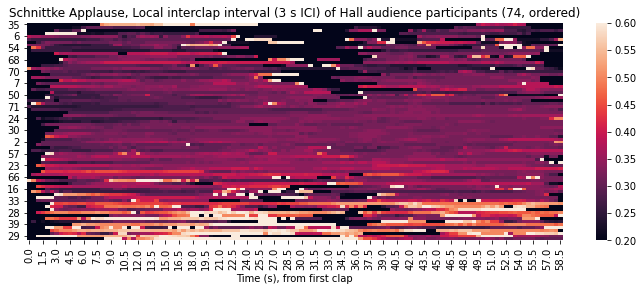

In [632]:
# now to show these as individual sequences
# sorted by distance from the median local ICI time series across audience, not absolute
#cm = plt.cm.get_cmap('twilight')
# df.filter(like='bbi', axis=0)

feat_set = Clap_Feats.copy()
feat_set.fillna(0,inplace=True)
feat_set = feat_set.loc[:,feat_set.sum()>1] # take out the few that barely move, could be recording error.
print(len(feat_set.columns))
dists = abs(feat_set.sub(feat_set.median(axis=1),axis = 0)).sum()*np.sign(feat_set.sub(feat_set.median(axis=1),axis = 0).sum())

df_A = Clap_Feats[dists.sort_values().index].copy()#*1000 # convert to milliseconds
df_A.fillna(0.01,inplace=True)
fig, ax = plt.subplots(figsize = [12,4])
chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.200, vmax=0.600)
plt.title('Schnittke Applause, Local interclap interval (3 s ICI) of Hall audience participants (74, ordered)')
plt.xlabel('Time (s), from first clap')
ax.set_xticklabels(np.round(df_A.iloc[ax.get_xticks()].index,2))
plt.savefig('SchnittkeApplause_ICIheatT.png',bbox_inches = 'tight',dpi=300)
plt.show()


In [633]:
musician_times

,TIME,LABEL
3,0.0,Clapping Start
4,2.0,Stand
5,12.0,bow
6,17.0,Start to leave stage
7,22.0,Claps in synch
8,26.0,Off stage
9,37.0,Claps in synch
10,37.0,Musicians enter hall
11,45.0,bow
12,51.0,bow


74


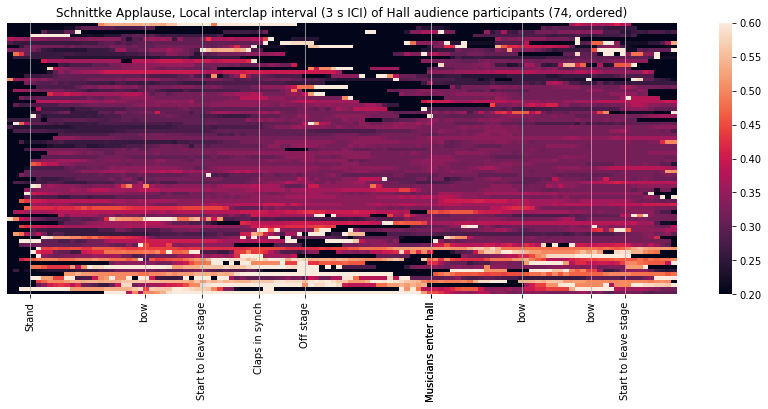

In [634]:
# now to show these as individual sequences
# sorted by distance from the median local ICI time series across audience, not absolute
#dists = Clap_Feats.sub(Clap_Feats.median(axis=1),axis = 0).sum()
feat_set = Clap_Feats.copy()
feat_set.fillna(0,inplace=True)
feat_set = feat_set.loc[:,feat_set.sum()>1] # take out the few that barely move, could be recording error.
print(len(feat_set.columns))
dists = abs(feat_set.sub(feat_set.median(axis=1),axis = 0)).sum()*np.sign(feat_set.sub(feat_set.median(axis=1),axis = 0).sum())

df_A = Clap_Feats[dists.sort_values().index].copy()#*1000 # convert to milliseconds
df_A.fillna(0.01,inplace=True)

fig, ax = plt.subplots(figsize = [15,5])
chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.200, vmax=0.600)
plt.title('Schnittke Applause, Local interclap interval (3 s ICI) of Hall audience participants (74, ordered)')
#plt.xlabel('Time (s), from first clap')
#plt.xticks(musician_times.TIME,musician_times.LABEL, rotation=45,ha='right')
subtimes= musician_times.loc[4:13]
new_xticks = len(df_A)*(subtimes.TIME-df_A.index[0])/(df_A.index[-1]-df_A.index[0])
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
ax.set_xticks(new_xticks)
ax.set_xticklabels(subtimes.LABEL)
ax.set_yticks([])
ax.grid()
plt.savefig('SchnittkeApplause_ICIheatEvents.png',bbox_inches = 'tight',dpi=300)
plt.show()


# Beethoven applause
Without synchronisation, as far as we can tell

In [635]:
peaks = pd.read_csv(claps_folder +'clapping_peaks/' + Applause_ints.loc[3,'files'],index_col=0)
peaks_IDs = peaks.columns
df_claps = peaks.fillna(0)
df_OnlyClaps = df_claps.astype(bool).astype(int)

# note these time are approximate to around the second, aligned roughly to final clapping excerpt times 
# Should be confirmed with better video interface than youtube
musician_times = pd.read_csv('./Data/Final_clapping_section_accelerometer/Final_Stage_events.csv',sep=",") #SV alignment for beeps
thisround = applause_times.loc[applause_times['Applause_N']==4,:].reset_index(drop=True)
# TIME LABEL
cl_start = thisround.loc[thisround['Event']=='Clapping Start','concert_time'].values
cl_end = thisround.loc[thisround['Event']=='Clapping End','concert_time'].values
cl_dur = cl_end - cl_start
musician_times = pd.DataFrame()
musician_times['TIME'] = thisround.loc[4:12,'concert_time']-cl_start
musician_times['LABEL'] = thisround['Event']
musician_times

,TIME,LABEL
4,0.0,Clapping Start
5,0.0,Musicians standing
6,5.0,bow
7,13.0,bow
8,16.0,Start to leave stage
9,19.0,Claps in synch
10,28.0,Off stage
11,31.6,MC starts talking
12,41.5,Clapping End


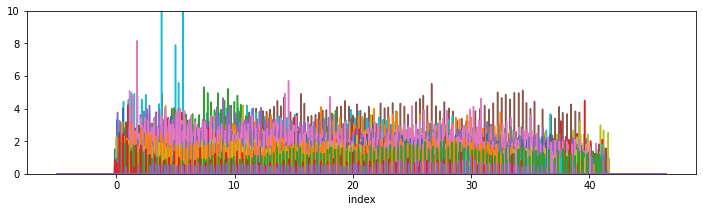

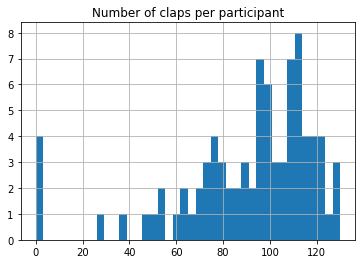

In [636]:
df_claps.plot(figsize = [12,3],legend = False)
plt.ylim([0,10])
plt.show()

# drop the clap amplitude for simpler analysis and count claps per participant
df_OnlyClaps.sum().hist(bins = 40)
plt.title('Number of claps per participant')
plt.show()

In [637]:
last_claps =df_claps.where(df_claps!=0).last_valid_index()
last_claps

41.64

Median time to start clapping: 0.9s
Inner quartile range: 1.2s


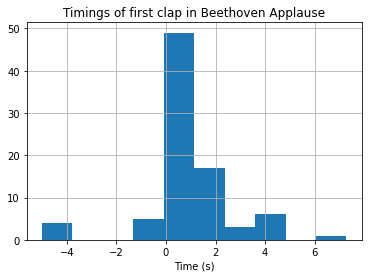

In [638]:
# Time to first clap.
first_claps =df_claps.ne(0).idxmax()
fig = first_claps.hist()
plt.xlabel('Time (s)')
plt.title('Timings of first clap in Beethoven Applause')

print('Median time to start clapping: ' + str(np.round(first_claps.median(),3)) + 's\nInner quartile range: ' + str(np.round(first_claps.quantile(0.75)-first_claps.quantile(0.25),3)) + 's')

In [639]:
# build database of clapping behaviour over measured intervals
t_interval = 1.5
sampletimes = np.arange(0,cl_dur-t_interval,0.5)
cols = df_OnlyClaps.columns
Clap_Feats = pd.DataFrame(index = sampletimes,columns = cols)

for samp in range(len(sampletimes)):
    t_0 = sampletimes[samp]
    sub_claps = df_OnlyClaps.loc[t_0-t_interval:t_0+t_interval,:] # Excerpt of claps
    these_claps = pd.Series(index = cols,dtype='float64')
    for partn in cols:
        ici = pd.Series(sub_claps.loc[sub_claps.loc[:,partn]>0].index,dtype='float64').diff()
        if ici.notna().sum()>1:
            these_claps[partn]=np.nanmedian(ici)
    Clap_Feats.loc[t_0,:] = these_claps
Clap_Feats.loc[:5]

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ086,AEQ087,AEQ088,AEQ089,AER090
0.0,NaN,NaN,0.25,0.32,0.24,NaN,NaN,0.26,0.35,0.34,...,NaN,NaN,0.26,NaN,NaN,NaN,NaN,0.22,0.3,NaN
0.5,0.21,NaN,0.25,0.3,0.26,NaN,0.36,0.26,0.3,0.26,...,NaN,0.34,0.26,0.28,NaN,NaN,0.3,0.24,0.26,NaN
1.0,0.21,NaN,0.24,0.3,0.26,0.48,0.36,0.27,0.32,0.32,...,0.29,0.34,0.26,0.28,NaN,NaN,0.3,0.24,0.32,NaN
1.5,0.21,NaN,0.24,0.3,0.27,0.32,0.36,0.27,0.32,0.32,...,0.28,0.34,0.26,0.3,NaN,NaN,0.28,0.24,0.34,1.04
2.0,0.22,NaN,0.24,0.29,0.28,0.3,0.35,0.28,0.32,0.32,...,0.28,0.32,0.32,0.3,0.51,NaN,0.29,0.24,0.35,0.62
2.5,0.23,NaN,0.24,0.28,0.28,0.3,0.35,0.27,0.32,0.29,...,0.28,0.32,0.28,0.3,0.44,NaN,0.32,0.24,0.38,0.24
3.0,0.24,NaN,0.24,0.29,0.28,0.28,0.34,0.24,0.32,0.32,...,0.28,0.32,0.32,0.3,0.42,NaN,0.28,0.25,0.4,0.26
3.5,0.24,NaN,0.24,0.29,0.28,0.28,0.34,0.23,0.32,0.45,...,0.28,0.32,0.3,0.3,0.38,NaN,0.3,0.26,0.42,0.25
4.0,0.26,NaN,0.24,0.29,0.28,0.28,0.34,0.23,0.32,0.58,...,0.28,0.32,0.31,0.3,0.38,NaN,0.28,0.26,0.41,0.25
4.5,0.26,NaN,0.24,0.28,0.29,0.28,0.34,0.25,0.32,0.36,...,0.28,0.32,0.3,0.3,0.33,NaN,0.28,0.26,0.41,0.26


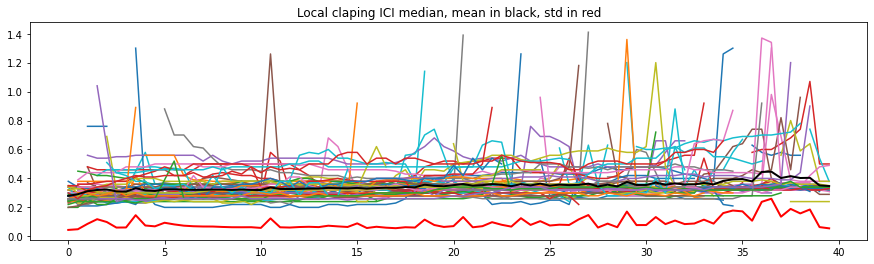

In [640]:
# to get an idea of what values these take
Clap_Feats.plot(legend=False,figsize=[15,4])
plt.title('Local claping ICI median, mean in black, std in red')
B = Clap_Feats.mean(axis=1)
B.plot.line(color = 'black',linewidth=2)
B = Clap_Feats.std(axis=1)
B.plot.line(color = 'red',linewidth=2)
plt.show()

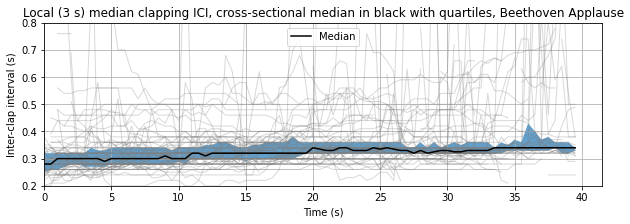

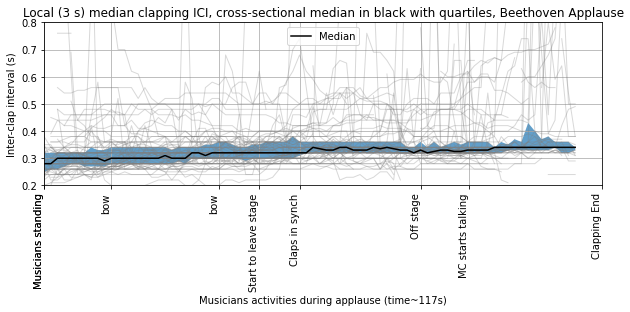

In [641]:
# pull out the quartile time series, allowing for nans
# 
df_A = Clap_Feats.copy()
df_feats = pd.DataFrame(index = df_A.index,columns= ['Median','LowerQ','UpperQ','Midrange','NotNa_C','NotNa_p'])
t_interval = 3

for i, row in df_A.iterrows():
    sub_row = row[row.notna()]
    if len(sub_row)>0:
        these_stats = {'Median':np.median(sub_row),'LowerQ':sub_row.quantile(q=0.25,interpolation='nearest'),'UpperQ':sub_row.quantile(q=0.75,interpolation='nearest'),
                       'Midrange':np.round(sub_row.quantile(q=0.75,interpolation='nearest')-sub_row.quantile(q=0.25,interpolation='nearest'),5),'NotNa_C':len(sub_row),'NotNa_p':len(sub_row)/len(row)}
        df_feats.loc[i,:] = these_stats
df_feats = df_feats.dropna()

#df_feats.loc[:10]

fig,ax = plt.subplots(1,1,figsize=[10,3])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.xlim([0,cl_dur])
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles, Beethoven Applause')
plt.savefig('BeethovenApplause_Local_ICI_medians_QuartileTS.png',bbox_inches = 'tight',dpi=300)
plt.show()



fig,ax = plt.subplots(1,1,figsize=[10,3])
df_A.plot(linewidth=1,color='grey',alpha=0.3,legend=False,ax = ax)
#ax.line(df_A.index,df_A)
df_feats.plot(y='Median',color="black", ax=ax)
x = np.array(df_feats.index)
y1 = np.array(df_feats.LowerQ,dtype=np.float32)
y2 = np.array(df_feats.UpperQ,dtype=np.float32)
ax.fill_between(x,y1,y2,alpha = 0.7)
plt.ylim([0.2,0.8])
plt.xlim([0,cl_dur])
plt.xlabel('Time (s)')
plt.xticks(musician_times.TIME,musician_times.LABEL, rotation=90, ha='right')
plt.grid()
plt.xlabel('Musicians activities during applause (time~117s)')
plt.ylabel('Inter-clap interval (s)')
plt.title('Local (3 s) median clapping ICI, cross-sectional median in black with quartiles, Beethoven Applause')
plt.savefig('BeethovenApplause_Local_ICI_medians_QuartileTS_MusEv.png',bbox_inches = 'tight',dpi=300)
plt.show()

81


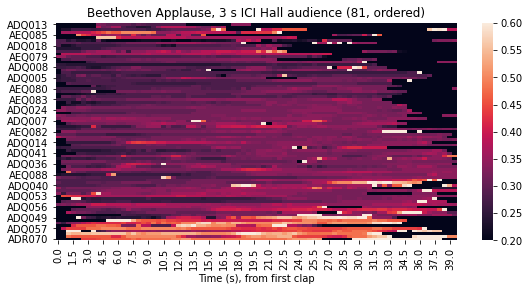

In [644]:
# now to show these as individual sequences
# sorted by distance from the median local ICI time series across audience, not absolute
#cm = plt.cm.get_cmap('twilight')
# df.filter(like='bbi', axis=0)

feat_set = Clap_Feats.copy()
feat_set.fillna(0,inplace=True)
feat_set = feat_set.loc[:,feat_set.sum()>1] # take out the few that barely move, could be recording error.
print(len(feat_set.columns))
dists = abs(feat_set.sub(feat_set.median(axis=1),axis = 0)).sum()*np.sign(feat_set.sub(feat_set.median(axis=1),axis = 0).sum())

df_A = Clap_Feats[dists.sort_values().index].copy()#*1000 # convert to milliseconds
df_A.fillna(0.01,inplace=True)
fig, ax = plt.subplots(figsize = [9,4])
chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.200, vmax=0.600)
plt.title('Beethoven Applause, 3 s ICI Hall audience (81, ordered)')
plt.xlabel('Time (s), from first clap')
ax.set_xticklabels(np.round(df_A.iloc[ax.get_xticks()].index,2))
plt.savefig('BeethovenApplause_ICIheatT.png',bbox_inches = 'tight',dpi=300)
plt.show()


81


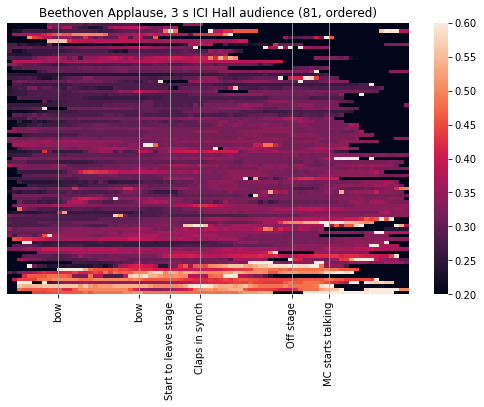

In [645]:
# now to show these as individual sequences
# sorted by distance from the median local ICI time series across audience, not absolute
#dists = Clap_Feats.sub(Clap_Feats.median(axis=1),axis = 0).sum()
feat_set = Clap_Feats.copy()
feat_set.fillna(0,inplace=True)
feat_set = feat_set.loc[:,feat_set.sum()>1] # take out the few that barely move, could be recording error.
print(len(feat_set.columns))
dists = abs(feat_set.sub(feat_set.median(axis=1),axis = 0)).sum()*np.sign(feat_set.sub(feat_set.median(axis=1),axis = 0).sum())

df_A = Clap_Feats[dists.sort_values().index].copy()#*1000 # convert to milliseconds
df_A.fillna(0.01,inplace=True)

fig, ax = plt.subplots(figsize = [9,5])
chart = sns.heatmap(data=df_A.transpose(), ax=ax,vmin=0.200, vmax=0.600)
plt.title('Beethoven Applause, 3 s ICI Hall audience (81, ordered)')
#plt.xlabel('Time (s), from first clap')
#plt.xticks(musician_times.TIME,musician_times.LABEL, rotation=45,ha='right')
subtimes= musician_times.loc[6:11]
new_xticks = len(df_A)*(subtimes.TIME-df_A.index[0])/(df_A.index[-1]-df_A.index[0])
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
ax.set_xticks(new_xticks)
ax.set_xticklabels(subtimes.LABEL)
ax.set_yticks([])
ax.grid()
plt.savefig('BeethovenApplause_ICIheatEvents.png',bbox_inches = 'tight',dpi=300)
plt.show()


# TODO 
regenerate the spatial clapping gifs with the re aligned assessement of clapping timing. 

Clapping_final_applause_peaks_ICI_5hz_hist.gif
